# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1011rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1012rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1013rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1011rep_25noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1012rep_25noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1013rep_25noiseLevel_MM_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.291343        0.207863  0.048928  0.302099  0.019950   
       0.25   0.309688        0.198184  0.051278  0.285198  0.033159   
       0.50   0.309408        0.196629  0.048719  0.256432  0.058113   
       0.75   0.311993        0.202810  0.046878  0.223647  0.086879   
       1.00   0.321055        0.199742  0.047612  0.190419  0.103221   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.206924  0.010339  0.040686  0.049853  0.000000  
       0.25  0.205202  0.007218  0.039210  0.052636  0.000320  
       0.50  0.193639  0.006056  0.039451  0.055743  0.001110  
       0.75  0.198532  0.006619  0.036775  0.063180  0.002172  
       1.00  0.199857  0.007525  0.033669  0.072563  0.003755

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.305836        0.196759  0.050731  0.286435  0.020061   
       0.25   0.304658        0.206755  0.048119  0.291968  0.032116   
       0.50   0.312981        0.194280  0.048933  0.262156  0.058701   
       0.75   0.314250        0.203614  0.047108  0.215979  0.086044   
       1.00   0.318955        0.192563  0.045919  0.187852  0.103597   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211093  0.009628  0.039375  0.047187  0.000000  
       0.25  0.197484  0.007396  0.038960  0.052606  0.000310  
       0.50  0.199176  0.006304  0.038765  0.058465  0.001049  
       0.75  0.200199  0.006305  0.036034  0.065846  0.002196  
       1.00  0.195326  0.007018  0.032573  0.073717  0.003678

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.295093        0.200419  0.050812  0.296802  0.019824   
       0.25   0.301987        0.195378  0.047827  0.284258  0.032334   
       0.50   0.313993        0.192505  0.050125  0.255480  0.060016   
       0.75   0.296104        0.204613  0.046538  0.229797  0.086161   
       1.00   0.303933        0.195805  0.045822  0.192272  0.105821   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.199706  0.010179  0.039041  0.053527  0.000000  
       0.25  0.209072  0.006962  0.039976  0.055368  0.000304  
       0.50  0.192628  0.006035  0.039233  0.058661  0.001090  
       0.75  0.209174  0.006637  0.037060  0.066333  0.002200  
       1.00  0.205514  0.007388  0.034696  0.072521  0.003703

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25   0.299425        0.200789  0.052951  0.264835  0.052532   
         0.50   0.294721        0.194646  0.061848  0.195068  0.111537   
         0.75   0.277530        0.202127  0.069365  0.127900  0.157772   
         1.00   0.270379        0.192059  0.080348  0.079256  0.171356   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205907  0.010049  0.039701  0.050189  0.000000  
         0.25  0.198549  0.011440  0.039493  0.054518  0.000135  
         0.50  0.181729  0.014475  0.039112  0.063956  0.000490  
         0.75  0.181940  0.017021  0.036023  0.080898  0.001054  
         1.00  0.172375  0.019937  0.032835  0.100350  0.001915

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.895904e+01  4.006396e+01      37.084890  5.668387e+01   
         0.25  4.619542e+06  2.317008e+06  216095.640266  1.398457e+06   
         0.50  5.512627e+06  3.556799e+06  338556.940696  2.153234e+06   
         0.75  5.929421e+06  4.100638e+06  420146.407102  2.663142e+06   
         1.00  5.939704e+06  4.650100e+06  473950.002116  3.042015e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.526675  5.609052e+01  5.574226e+01      18.547885   
         0.25  473321.903047  2.255882e+06  2.681733e+06  434755.011449   
         0.50  734947.430038  3.745038e+06  3.244573e+06  640441.426523   
         0.75  898718.909951  4.746496e+06  3.532781e+06  777475.366456   
         1.00  975300.065584  5.461227e+06  3.825207e+06  842669.442039   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.455648  
         0.25     180672.234252  
         0.50     287738.019576  
         0.75     364499.225807  
         1.00     398095.750592

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,,Missing Values,% of Total Values


,,Missing Values,% of Total Values


# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


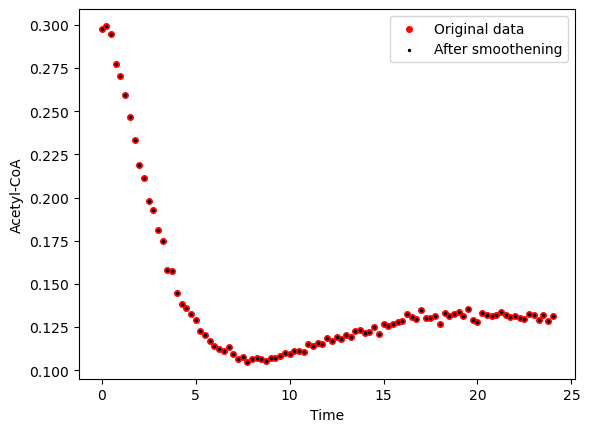

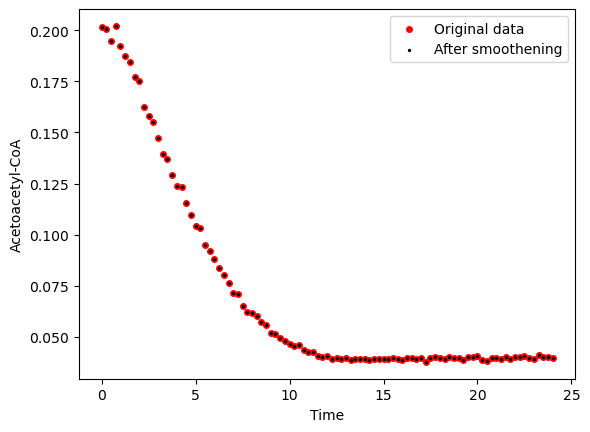

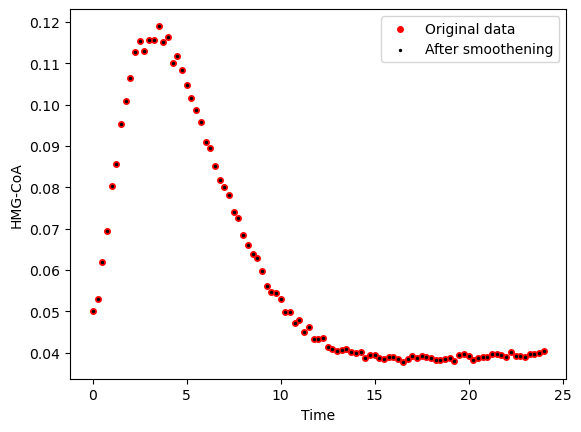

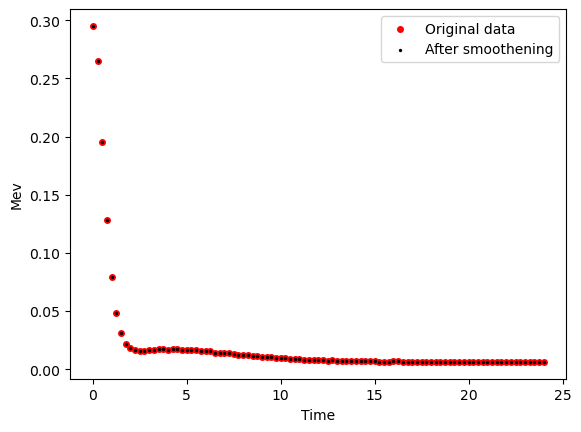

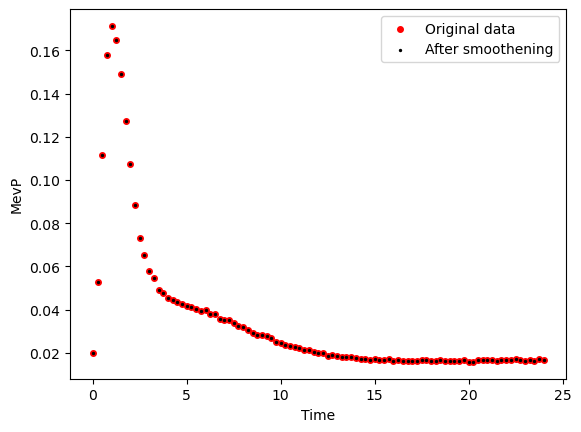

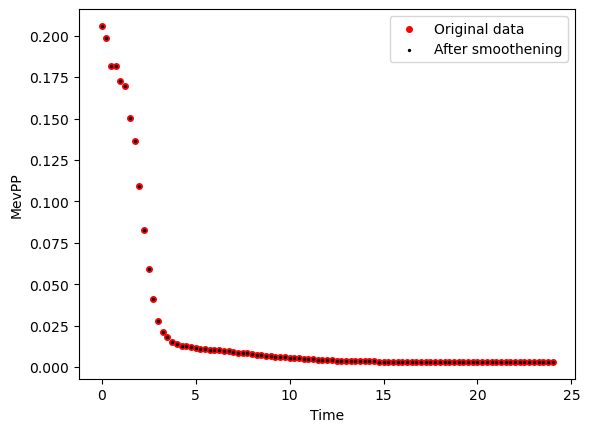

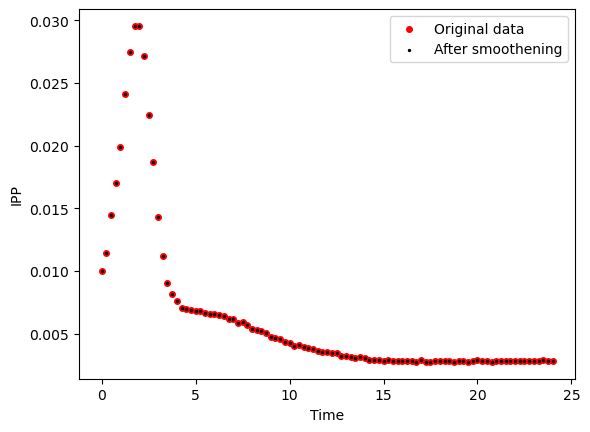

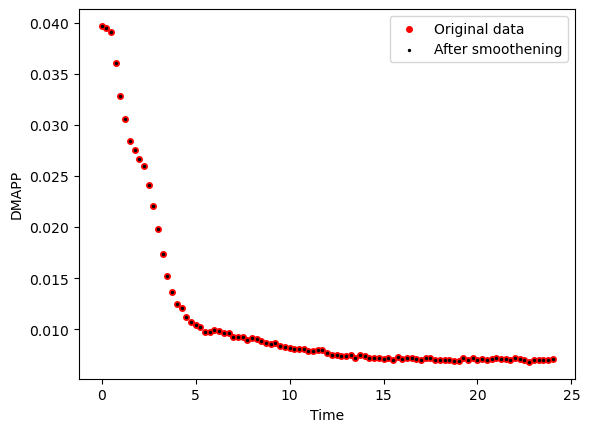

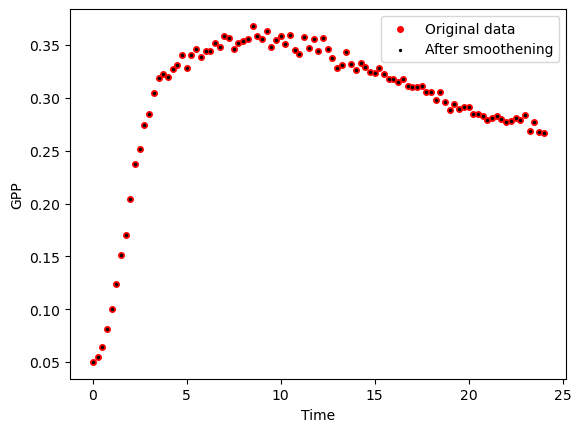

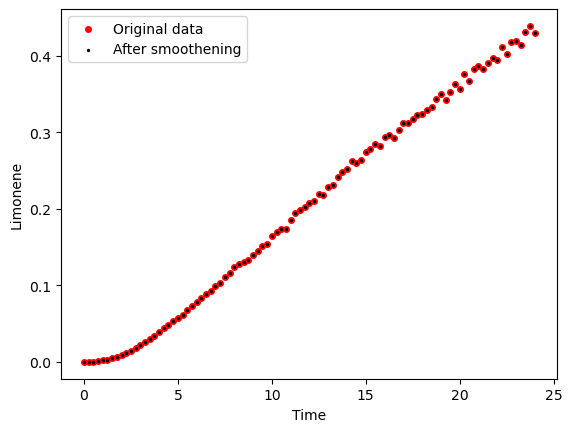

Strain Strain 2


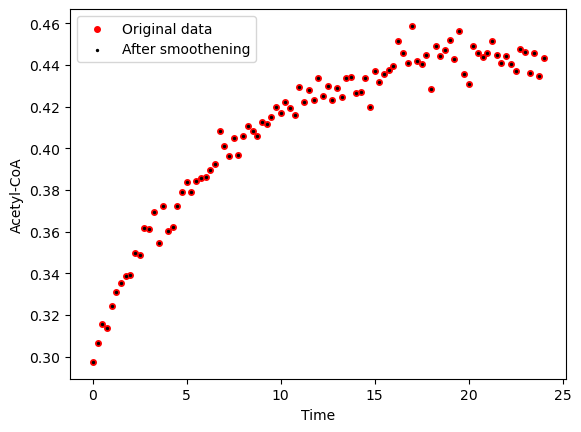

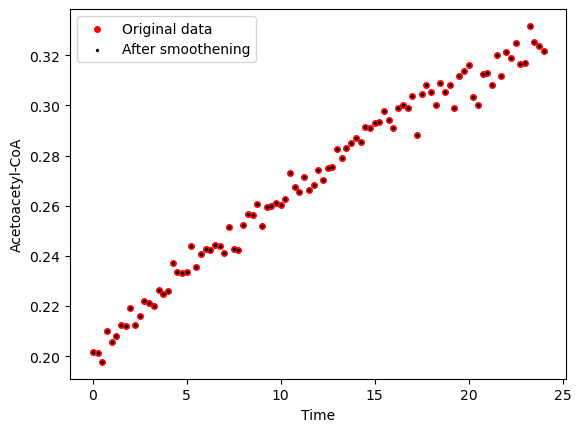

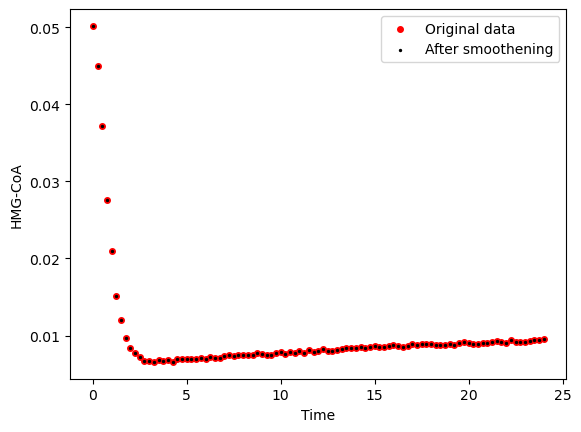

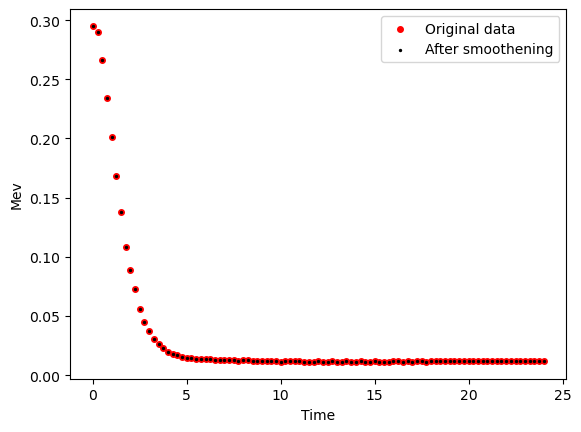

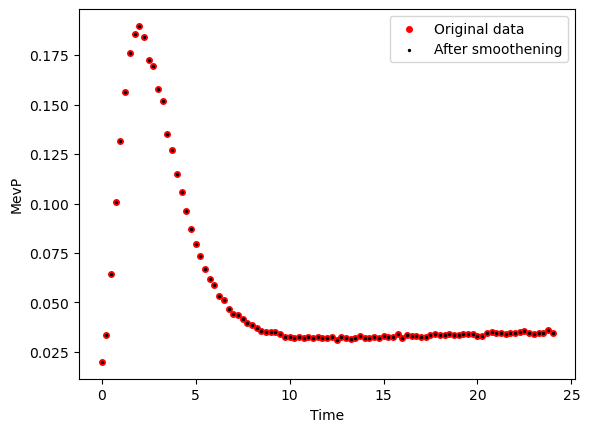

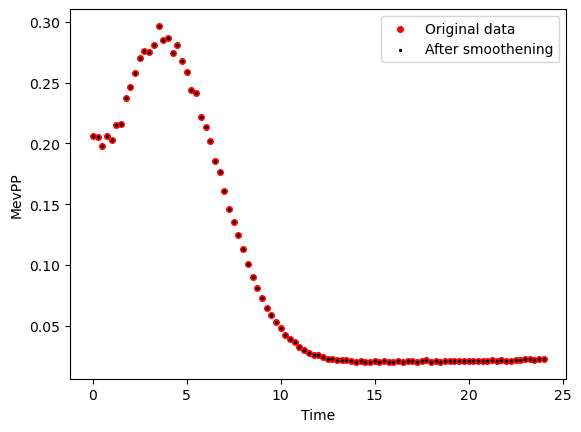

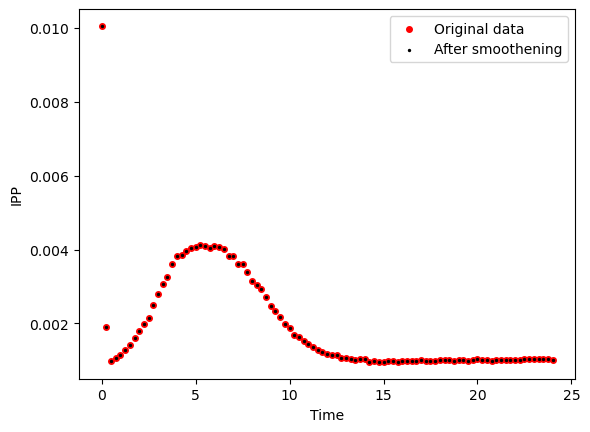

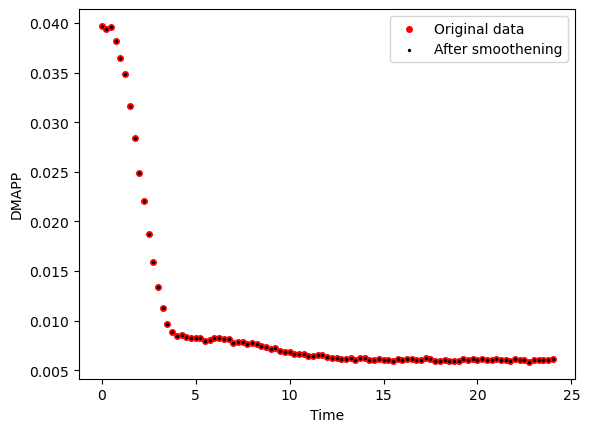

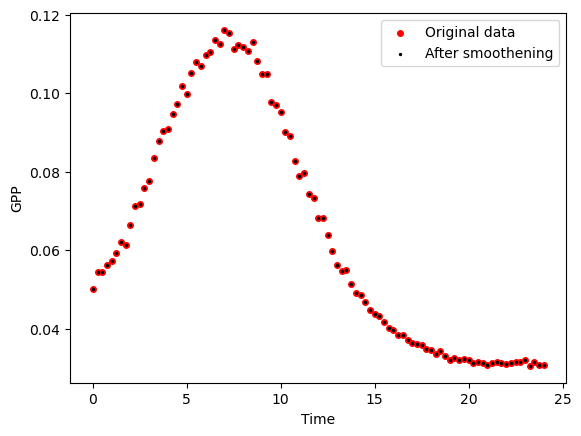

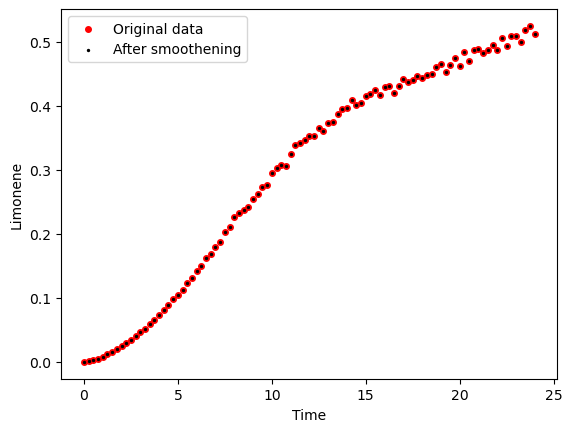

Strain Strain 3


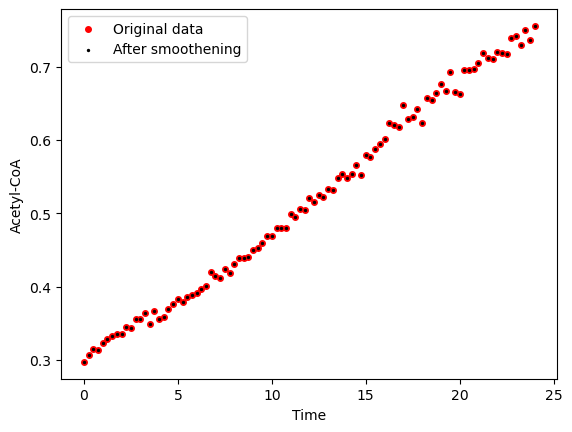

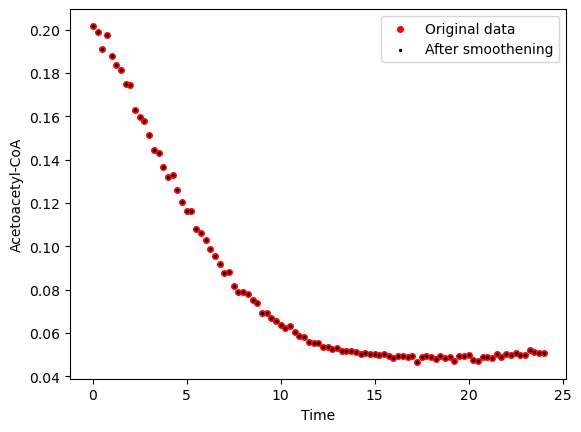

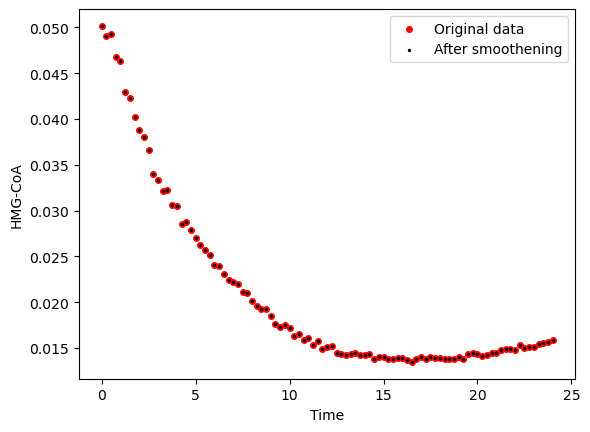

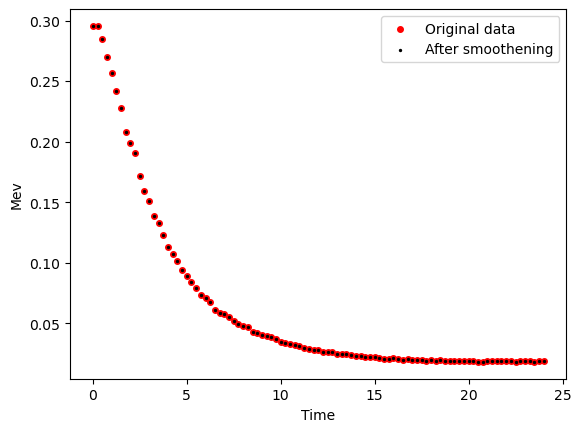

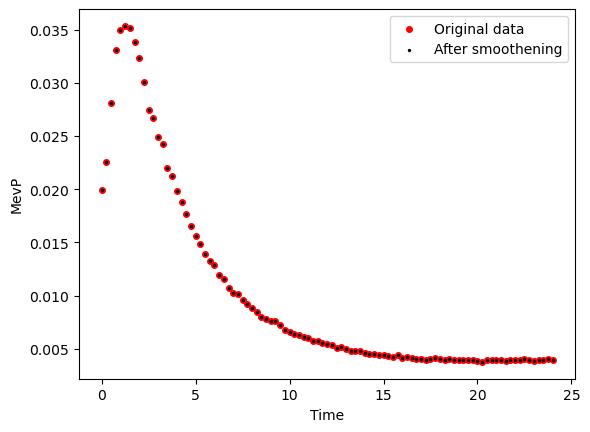

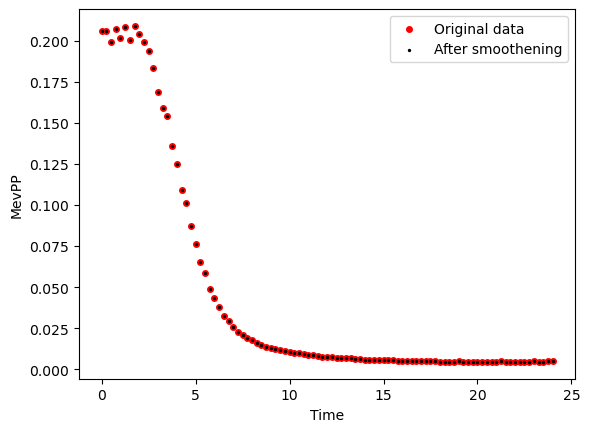

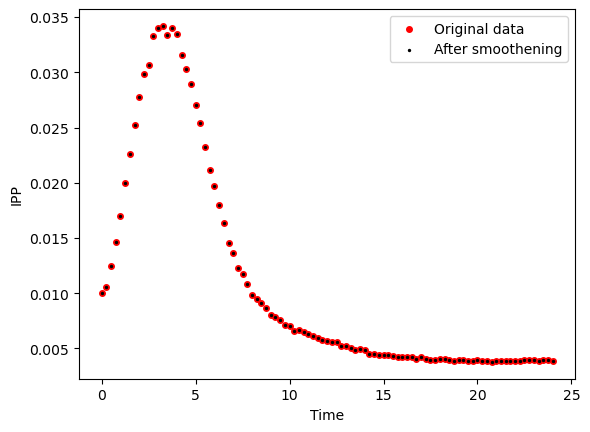

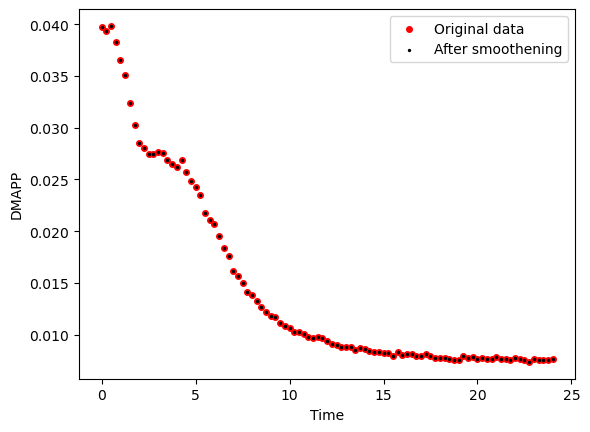

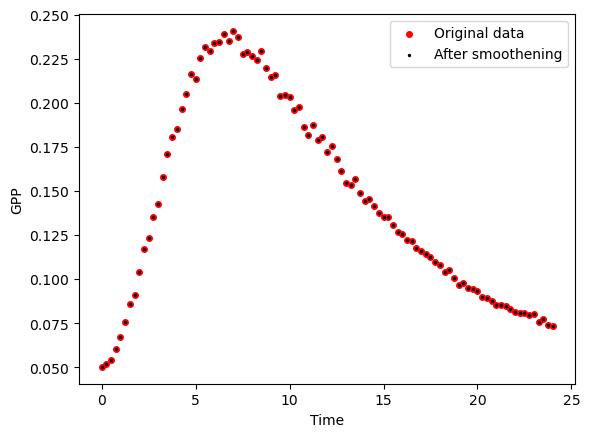

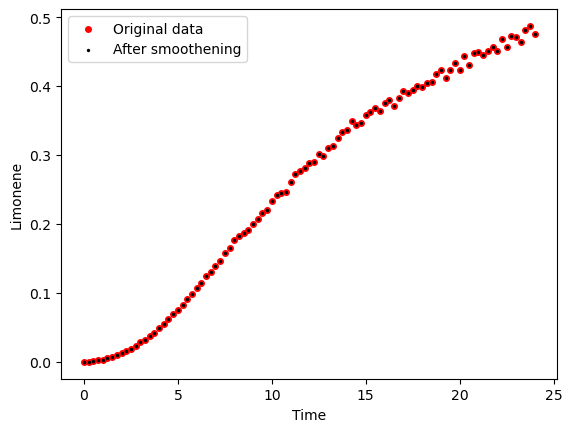

Strain WT


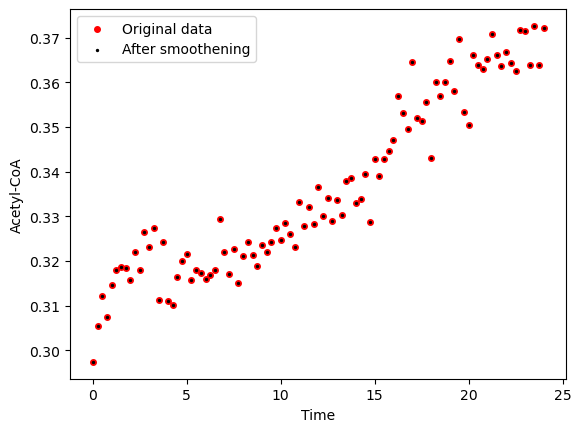

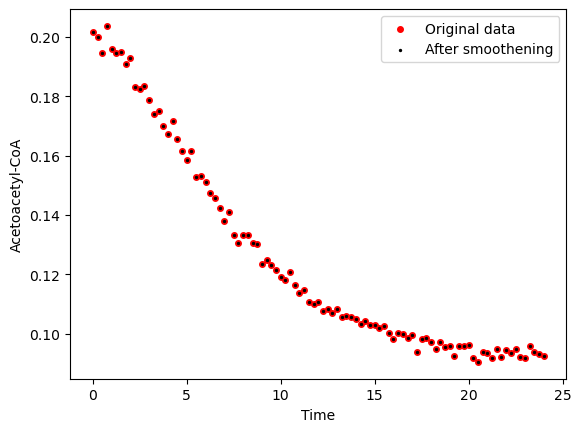

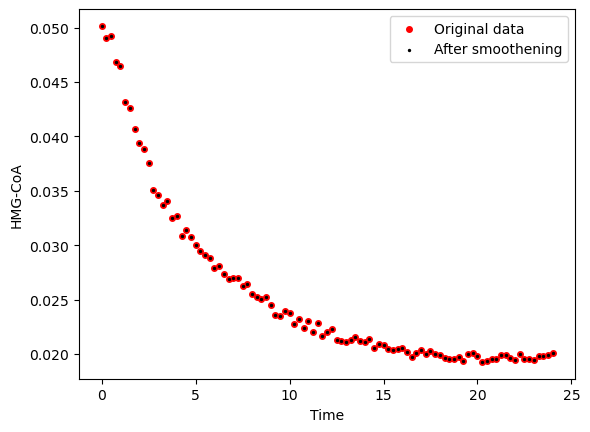

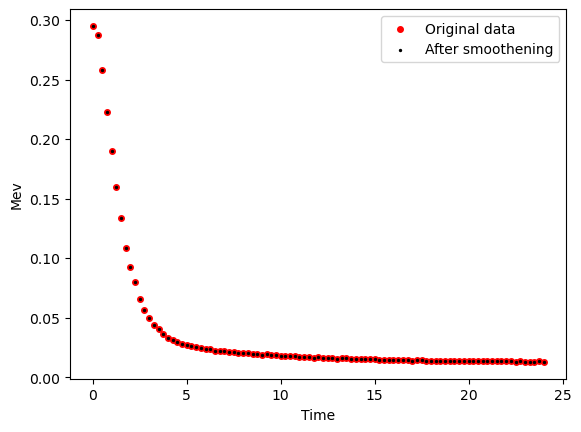

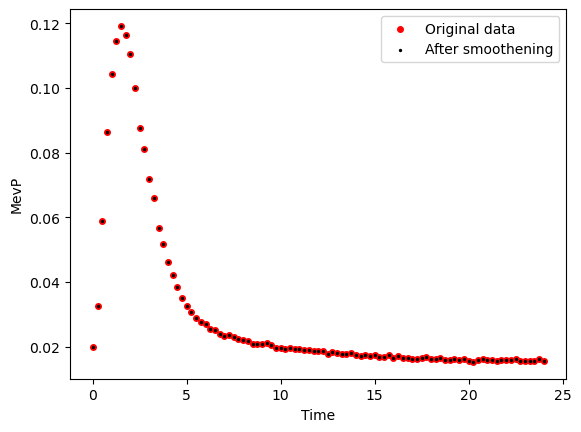

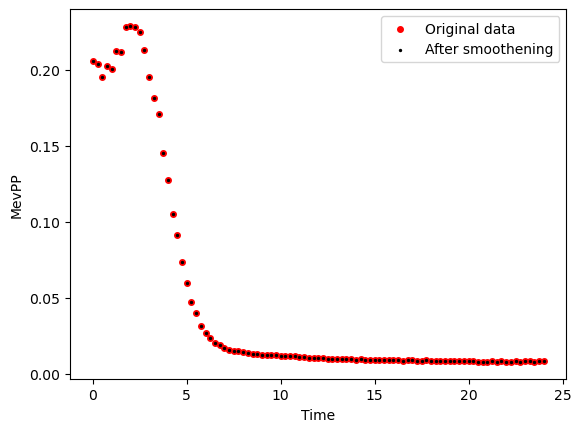

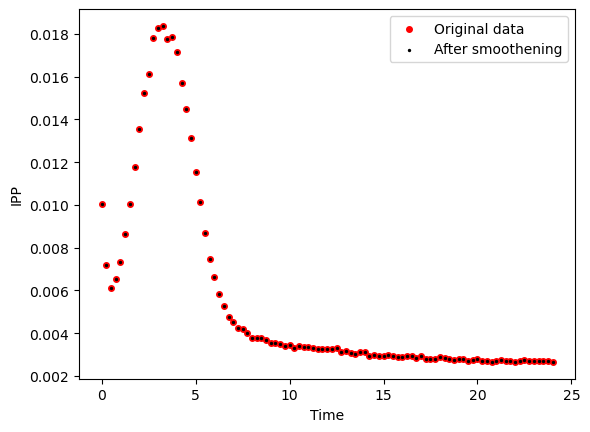

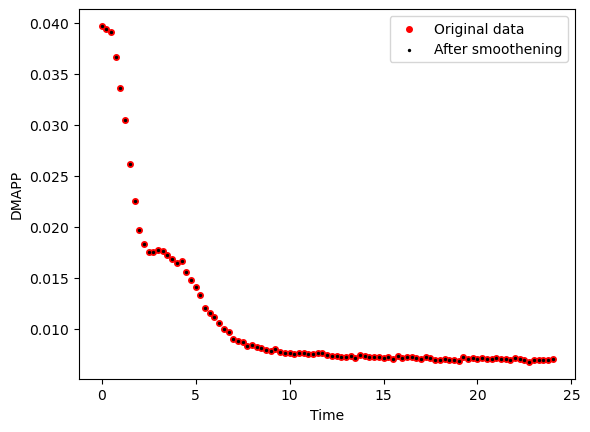

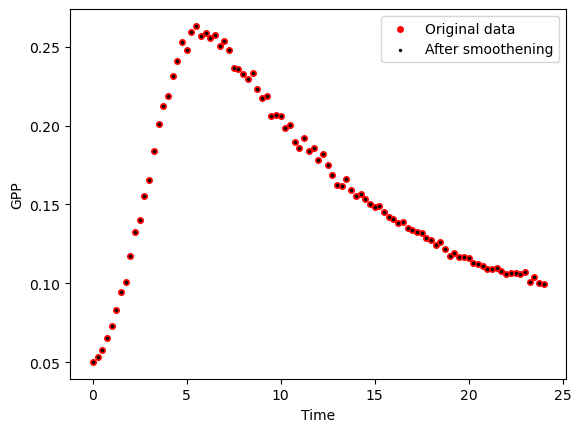

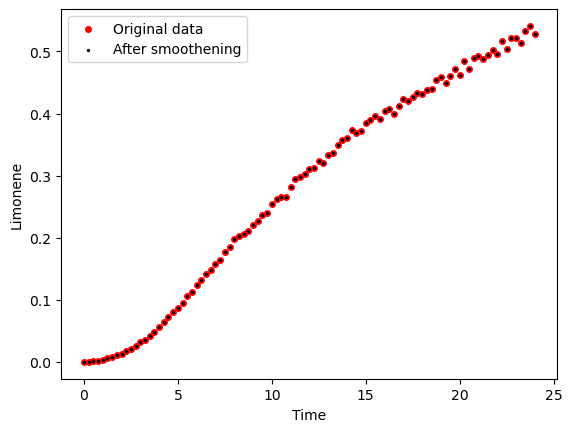

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


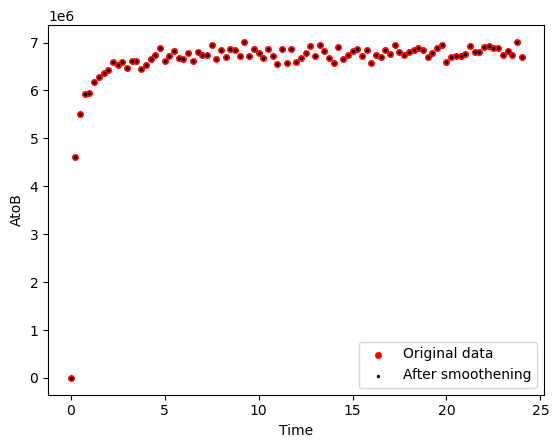

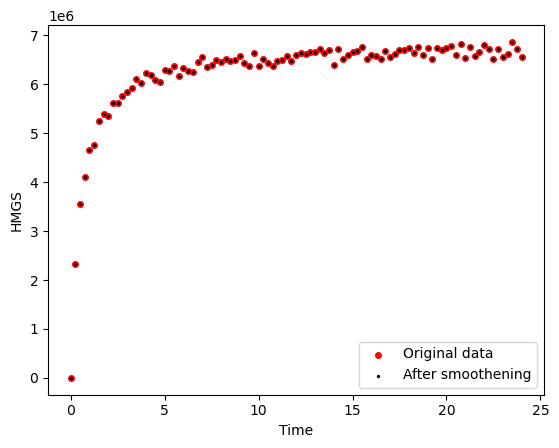

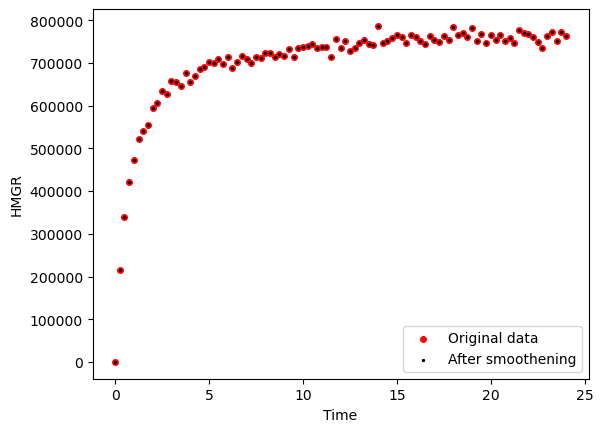

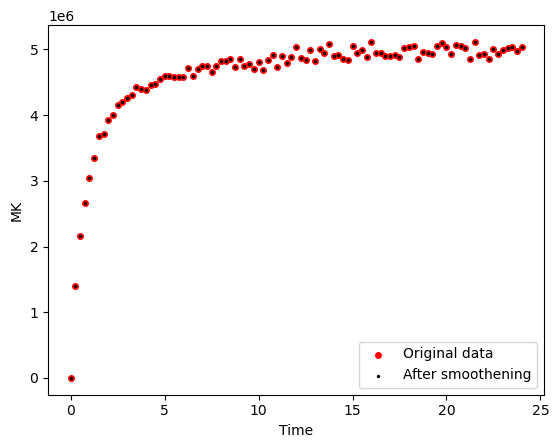

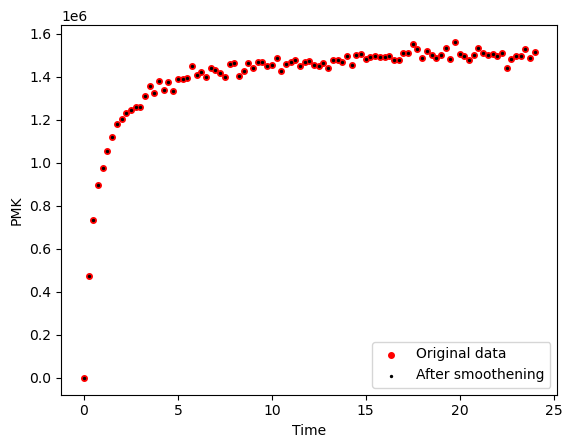

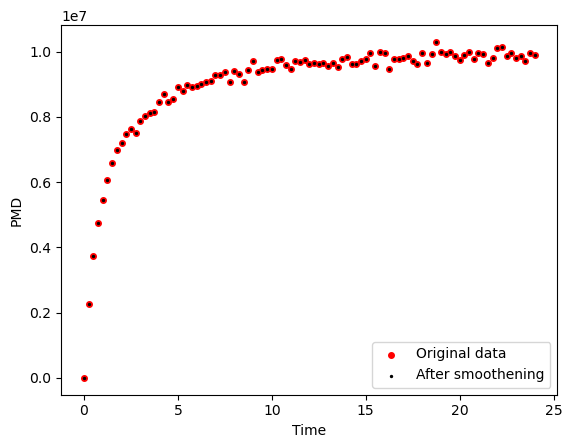

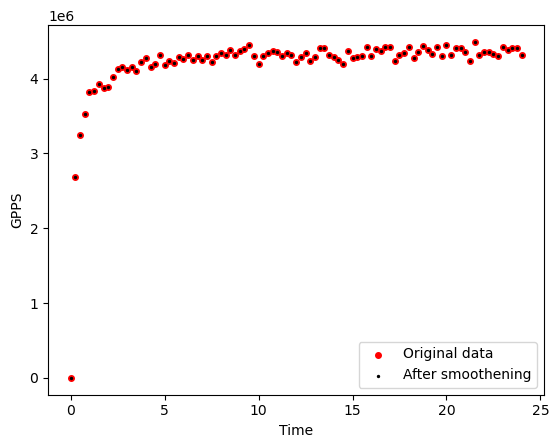

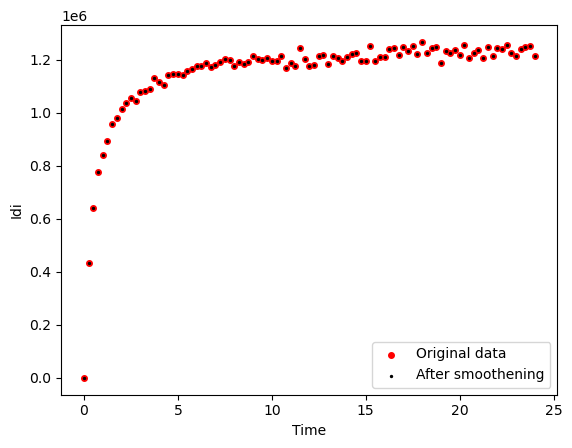

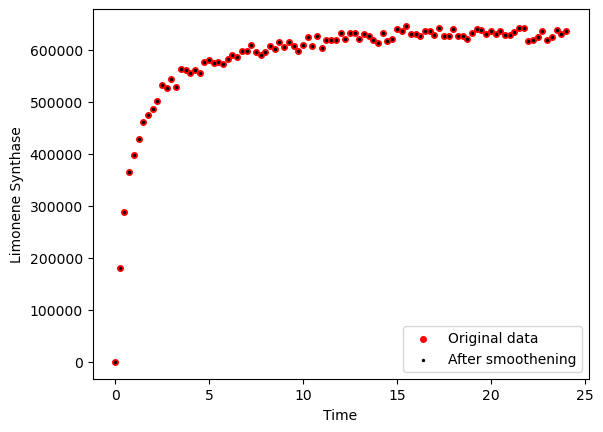

Strain Strain 2


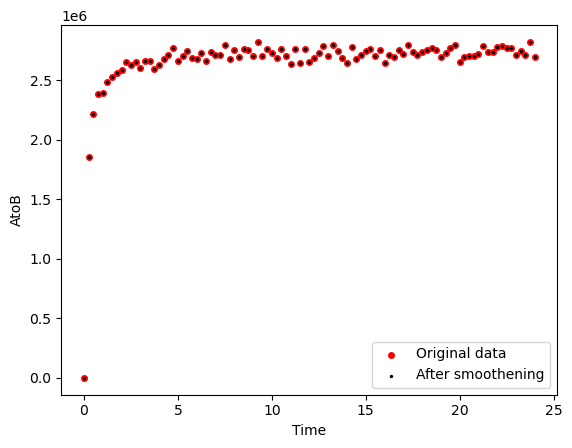

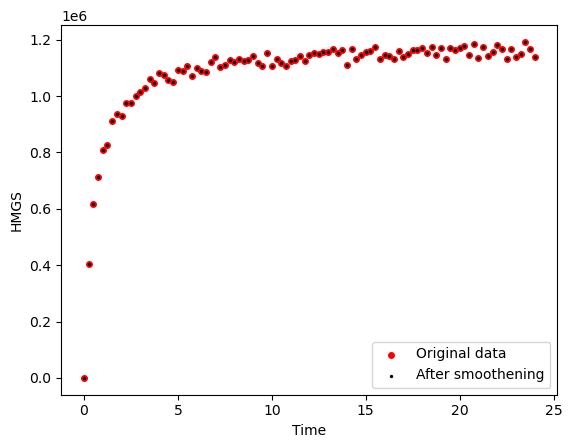

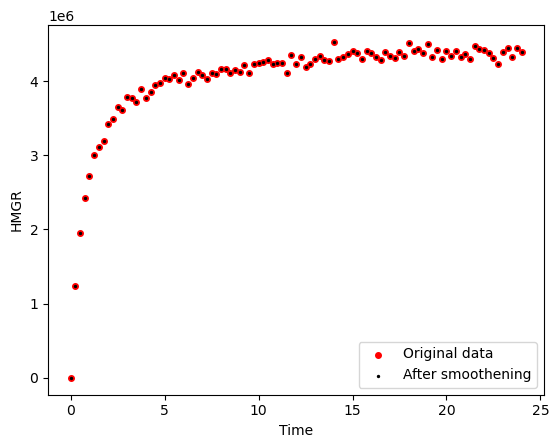

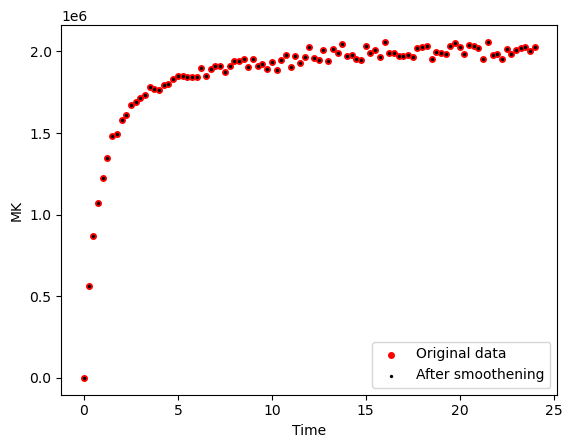

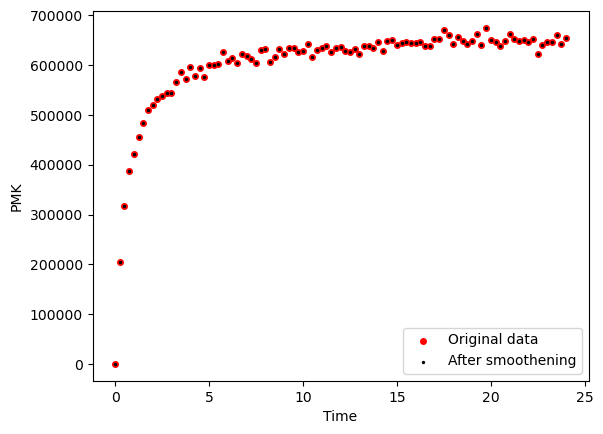

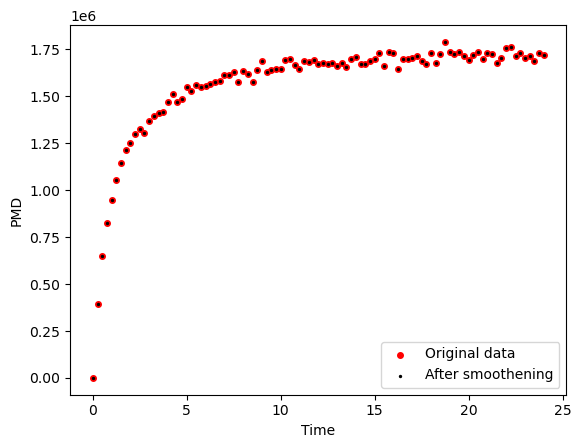

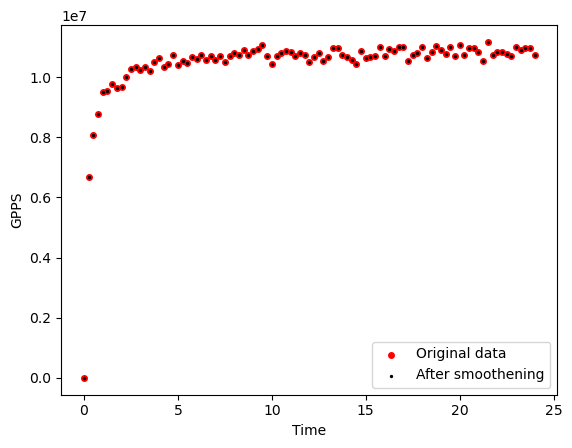

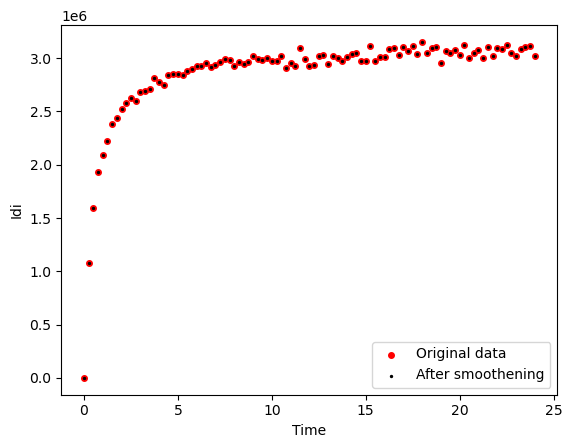

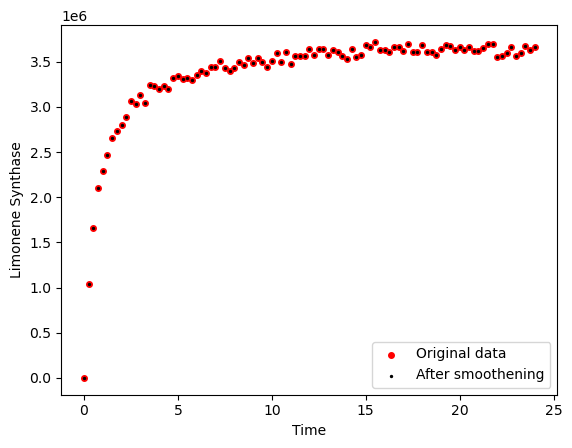

Strain Strain 3


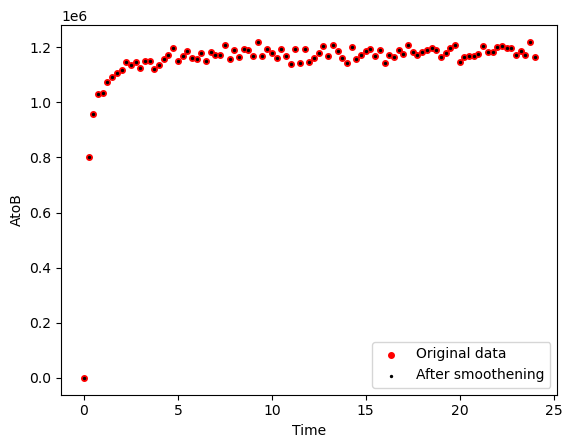

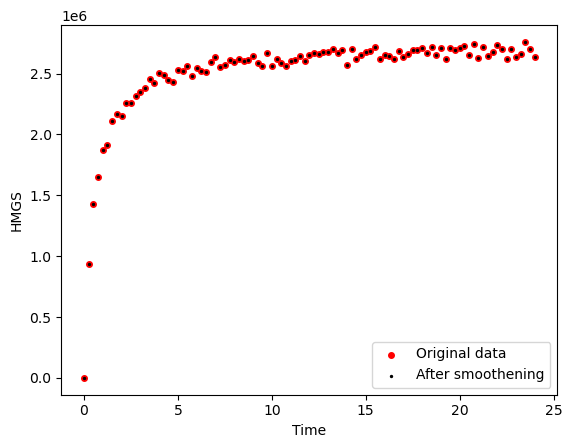

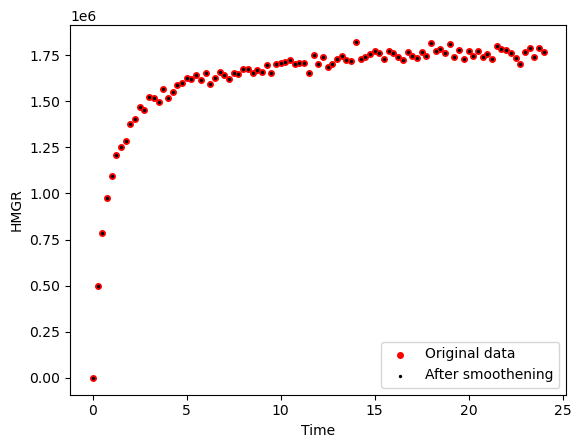

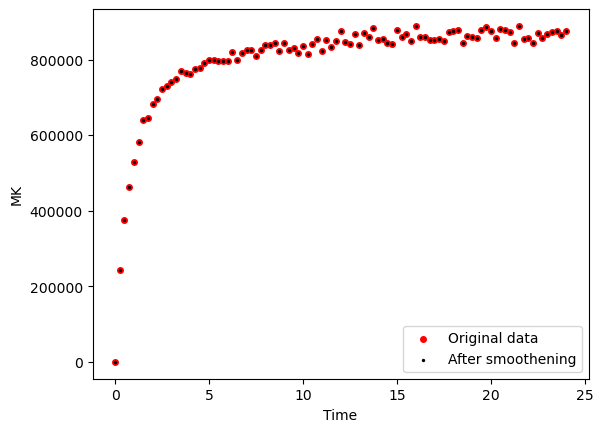

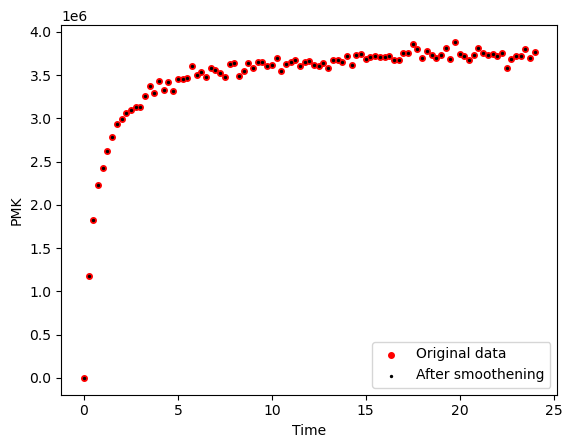

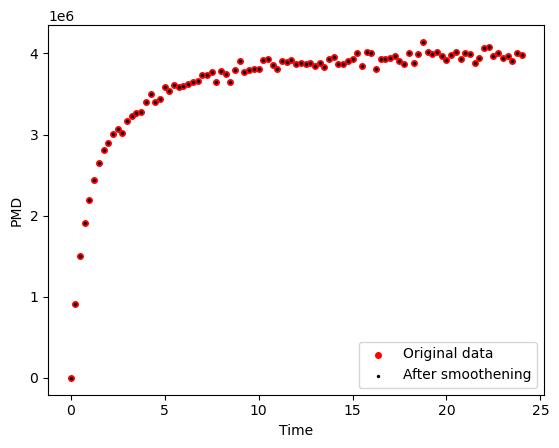

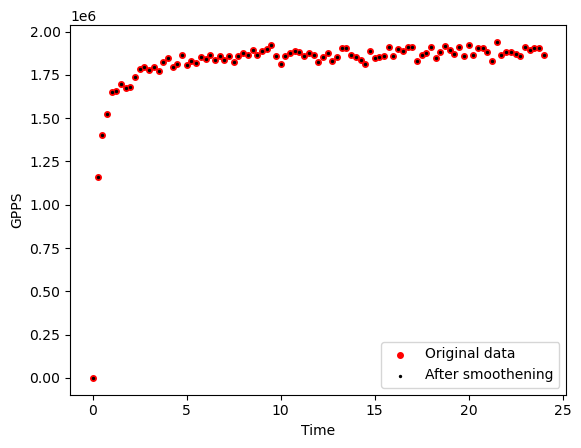

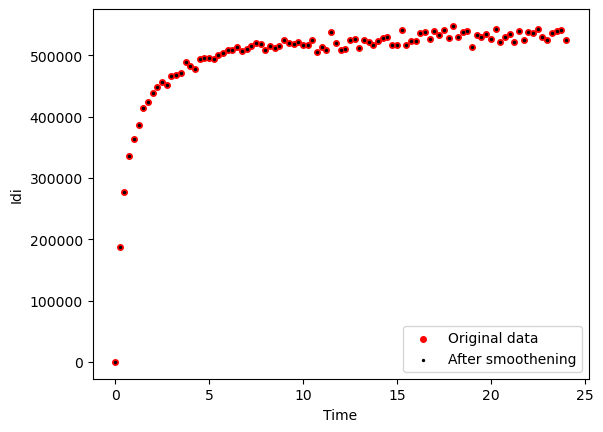

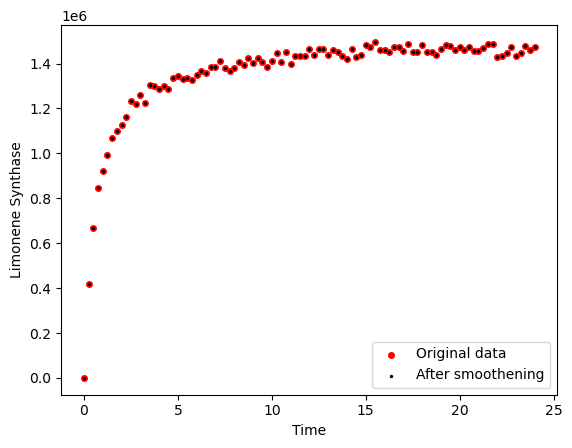

Strain WT


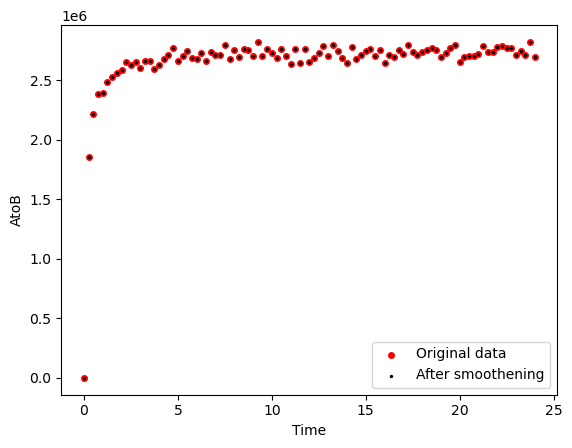

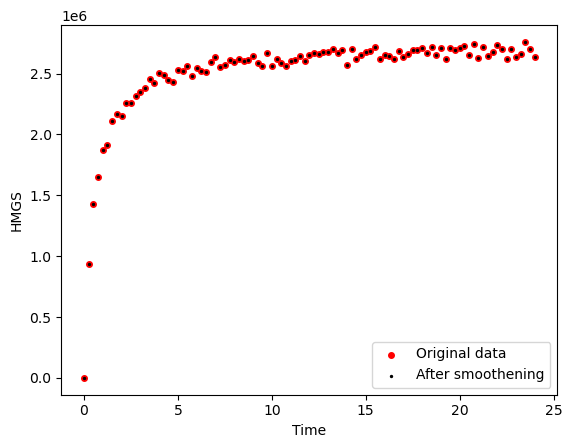

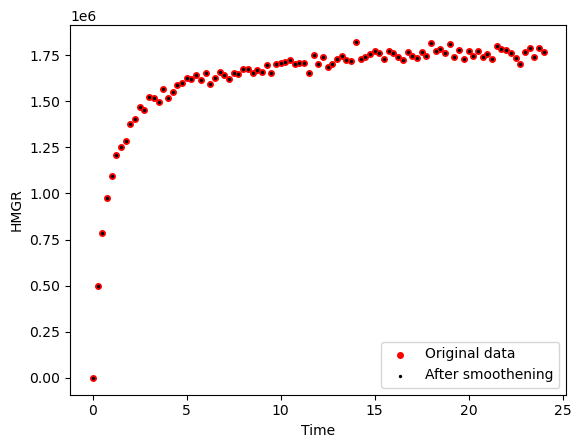

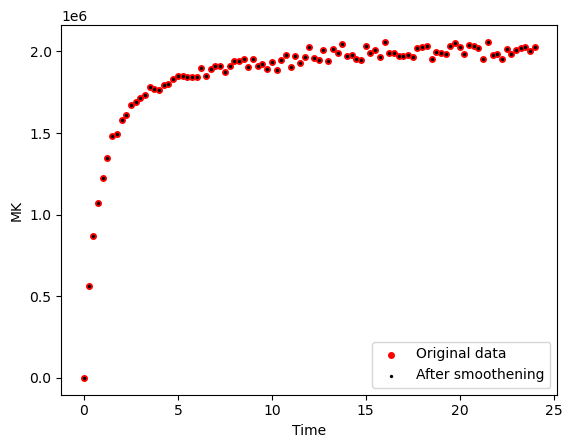

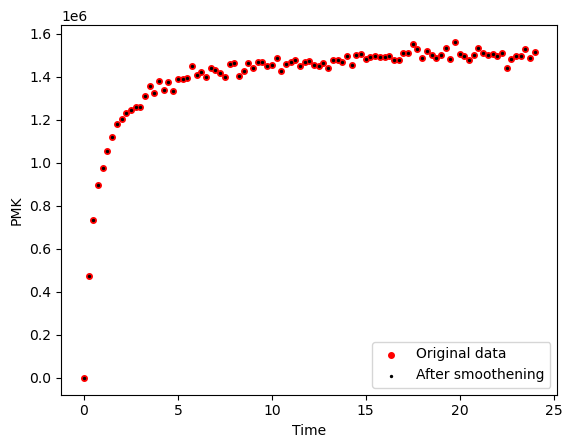

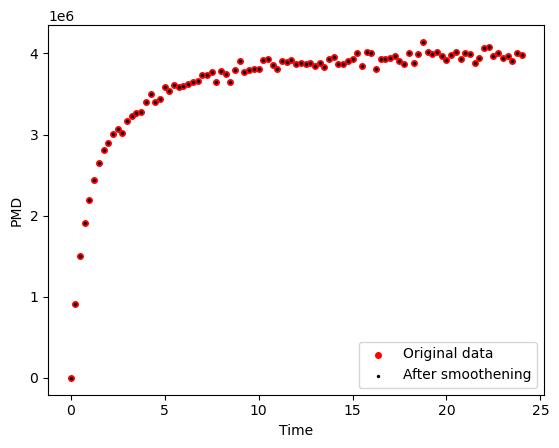

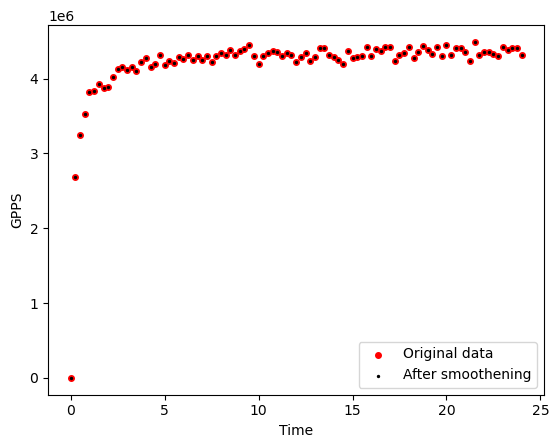

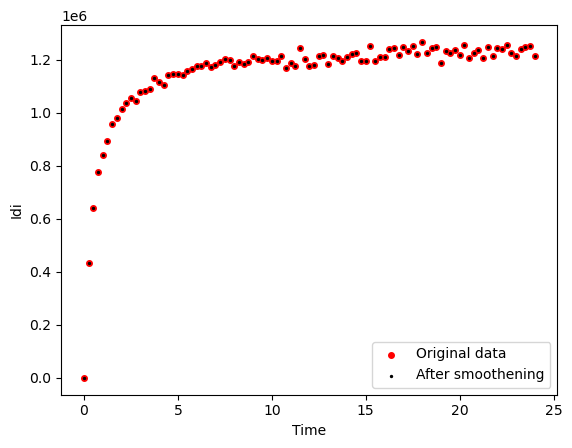

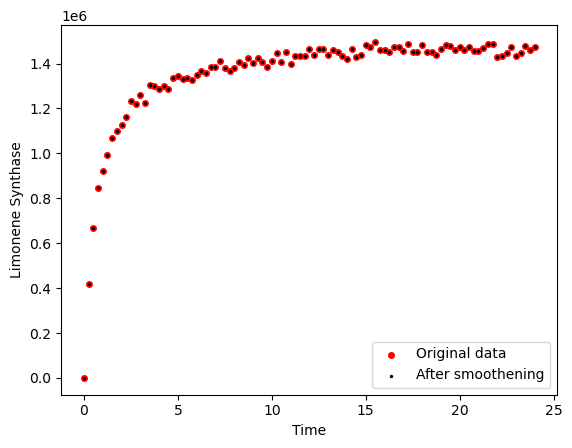

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25    0.299425        0.200789  0.052951  0.264835  0.052532   
         0.50    0.294721        0.194646  0.061848  0.195068  0.111537   
         0.75    0.277530        0.202127  0.069365  0.127900  0.157772   
         1.00    0.270379        0.192059  0.080348  0.079256  0.171356   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.371463        0.091969  0.019446  0.013122  0.015384   
         23.25   0.363803        0.095999  0.019811  0.013026  0.015522   
         23.50   0.372636        0.093898  0.019842  0.012892  0.015438   
         23.75   0.363945        0.093143  0.019896  0.013389  0.016026   
         24.00   0.372087        0.092351  0.020105  0.013010  0.015513   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205907  0.010049  0.039701  0.050189  0.000000  ...   
         0.25   0.198549  0.011440  0.039493  0.054518  0.000135  ...   
         0.50   0.181729  0.014475  0.039112  0.063956  0.000490  ...   
         0.75   0.181940  0.017021  0.036023  0.080898  0.001054  ...   
         1.00   0.172375  0.019937  0.032835  0.100350  0.001915  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.008232  0.002718  0.006955  0.107019  0.521730  ...   
         23.25  0.008189  0.002692  0.006934  0.101022  0.513163  ...   
         23.50  0.008026  0.002724  0.006915  0.103794  0.533279  ...   
         23.75  0.008161  0.002687  0.006938  0.100045  0.541078  ...   
         24.00  0.008312  0.002659  0.007016  0.099497  0.528270  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.004795       -0.001757  0.013577 -0.188448  0.221252   
         0.25    -0.012800       -0.004460  0.022148 -0.207953  0.192239   
         0.50    -0.030395       -0.007162  0.030719 -0.227459  0.163225   
         0.75    -0.041734       -0.011562  0.033593 -0.219354  0.113709   
         1.00    -0.045839       -0.014013  0.033330 -0.162774  0.032755   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004909        0.000722  0.000303 -0.000040 -0.000583   
         23.25   -0.005838        0.001533  0.000411 -0.000071  0.000314   
         23.50    0.000556       -0.000837  0.000561  0.000056  0.000304   
         23.75    0.008602       -0.005579  0.000396  0.000092 -0.000055   
         24.00    0.016648       -0.010320  0.000231  0.000128 -0.000415   

                                                                      
                   MevPP       IPP     DMAPP       GPP      Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.047891  0.007218  0.003028  0.007538  9.063289e-07  
         0.25  -0.040680  0.008680 -0.001926  0.029110  9.504149e-04  
         0.50  -0.033469  0.010143 -0.006880  0.050681  1.899923e-03  
         0.75  -0.026654  0.012350 -0.009624  0.070129  2.967370e-03  
         1.00  -0.029971  0.013245 -0.010684  0.087272  4.020624e-03  
...                  ...       ...       ...       ...           ...  
WT       23.00 -0.000030 -0.000013  0.000057 -0.004306  1.974979e-02  
         23.25  0.000033 -0.000024  0.000148 -0.005856  1.977451e-02  
         23.50  0.000053 -0.000050  0.000050 -0.006409  1.639770e-02  
         23.75  0.000446 -0.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

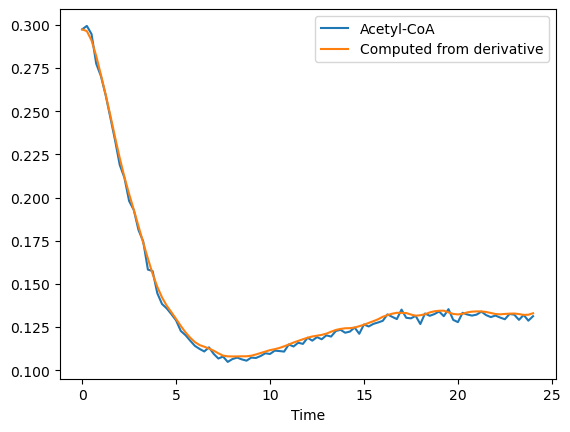

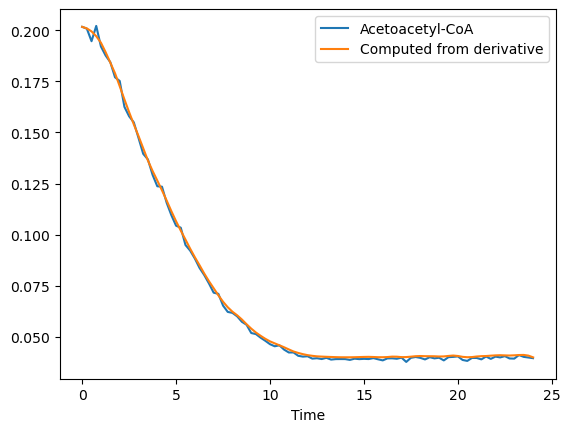

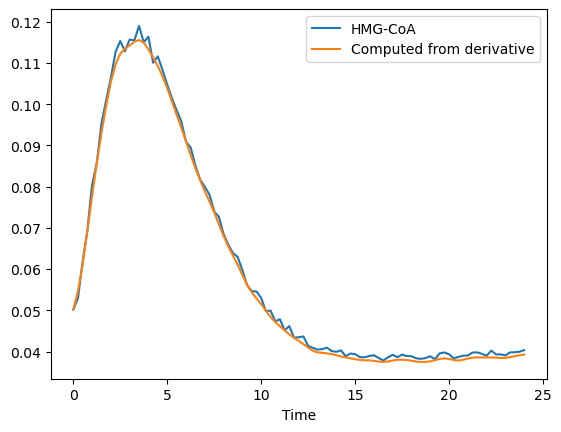

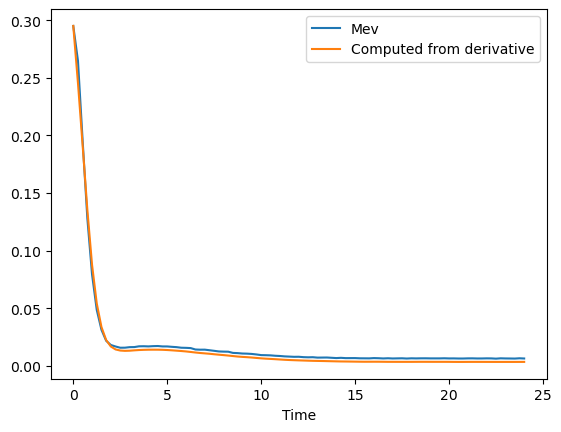

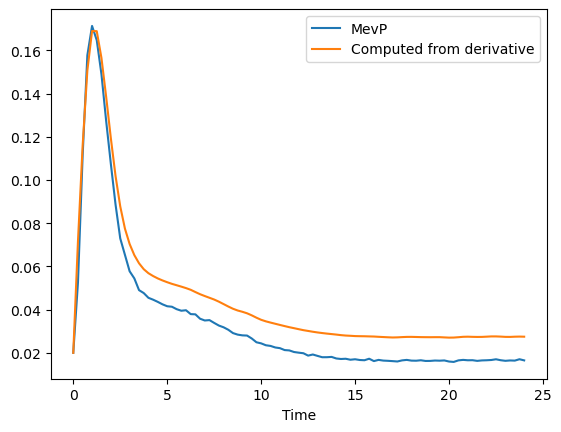

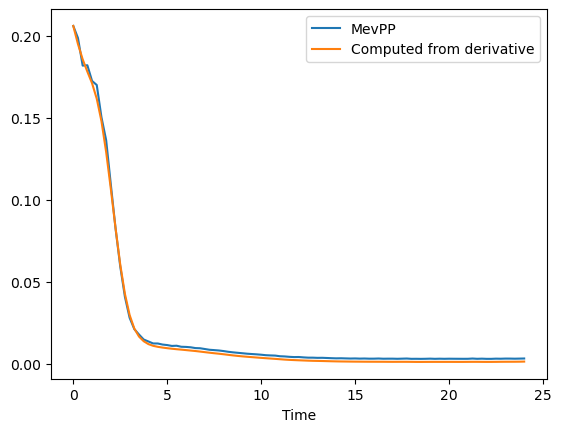

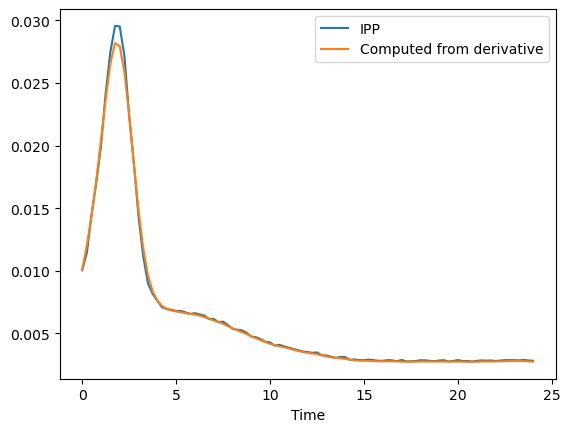

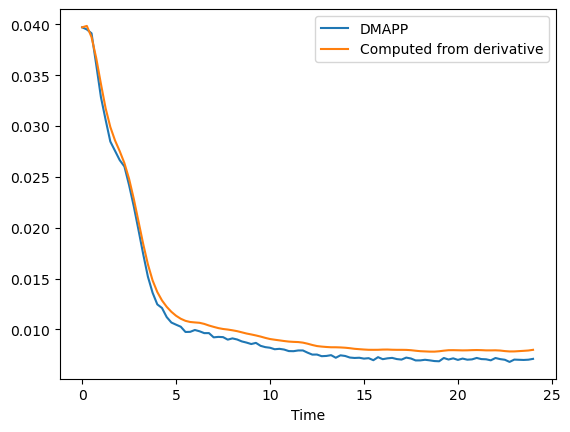

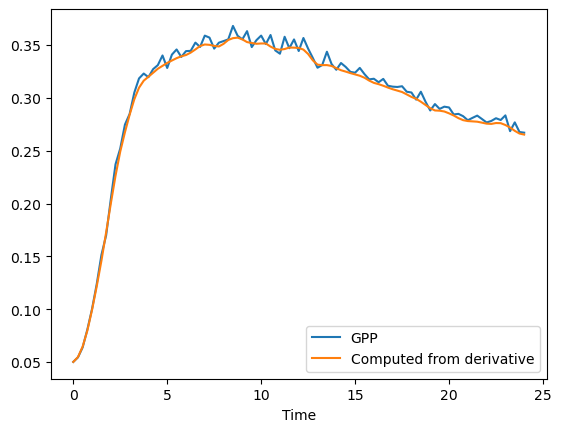

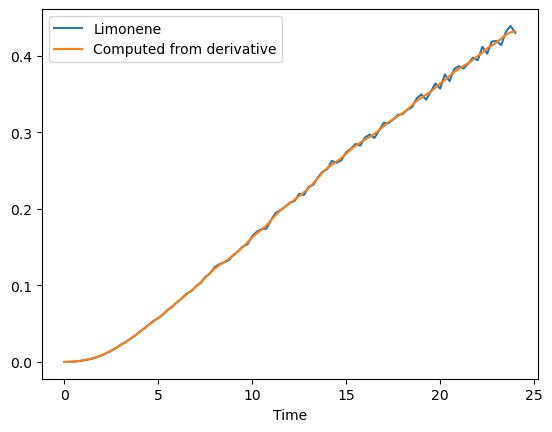

'Time profile from derivative vs. actual profile for Strain 2'

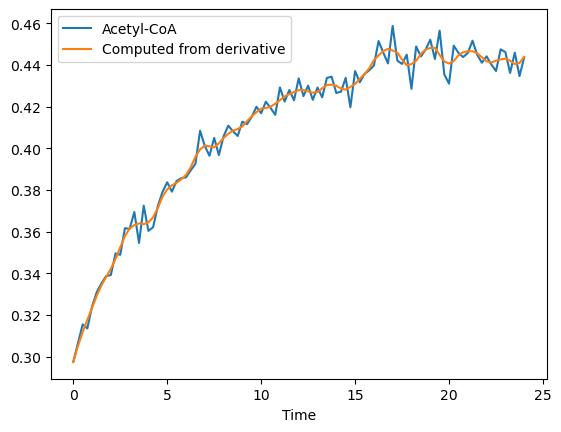

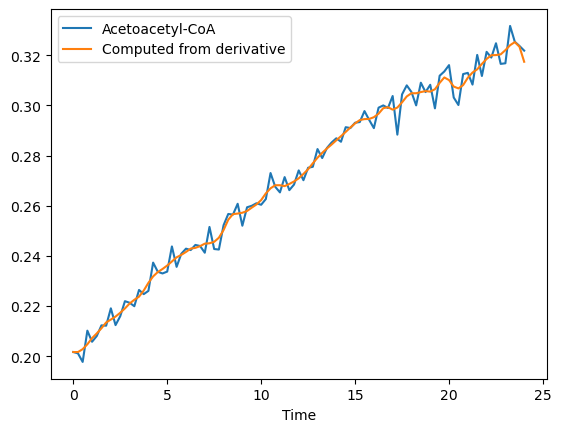

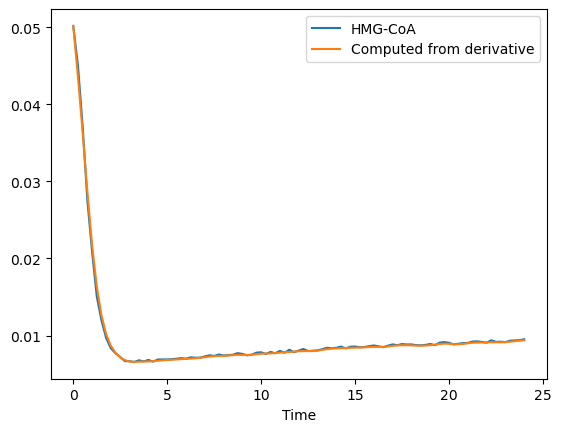

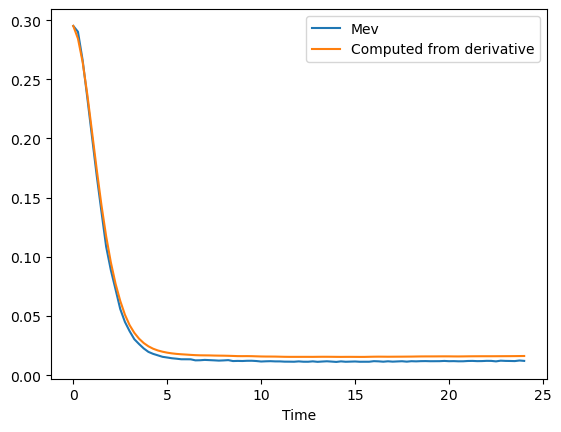

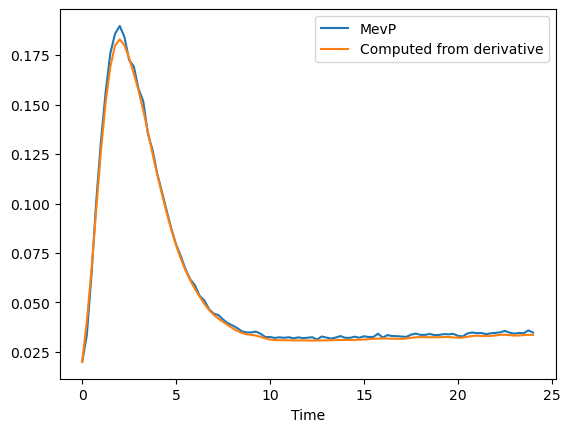

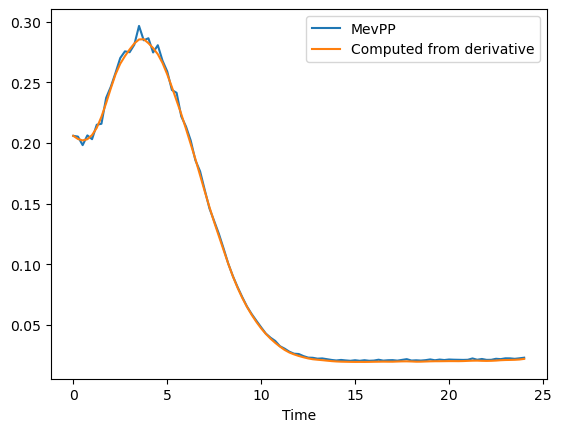

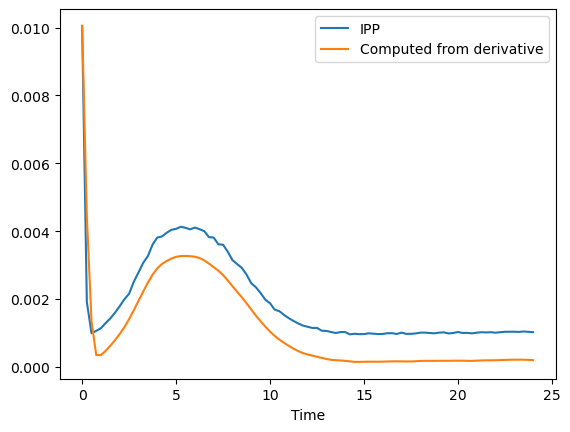

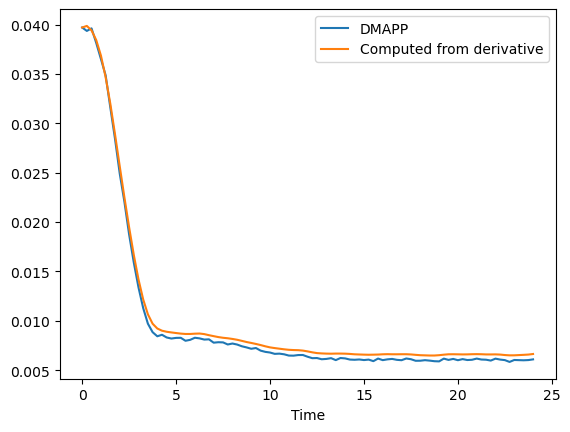

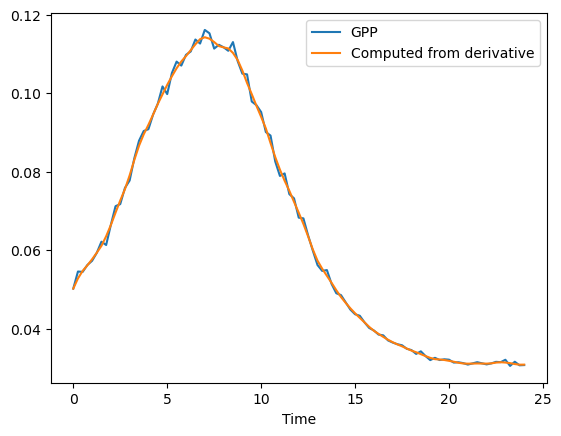

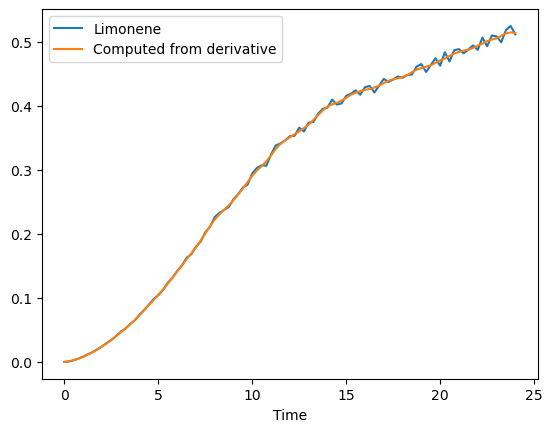

'Time profile from derivative vs. actual profile for Strain 3'

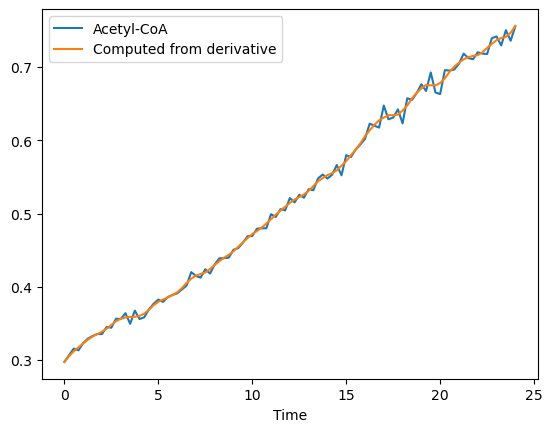

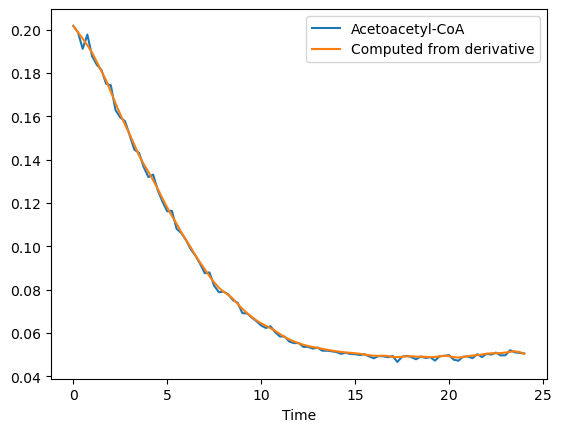

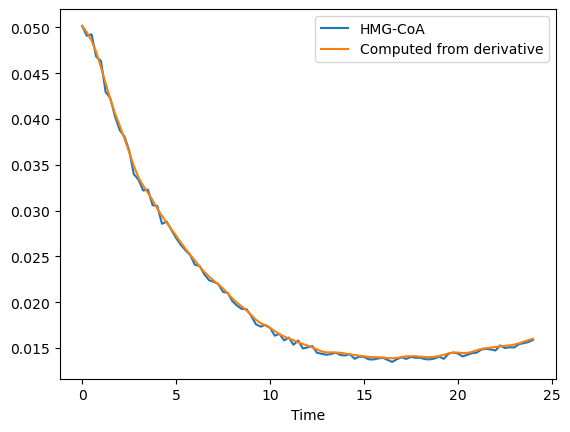

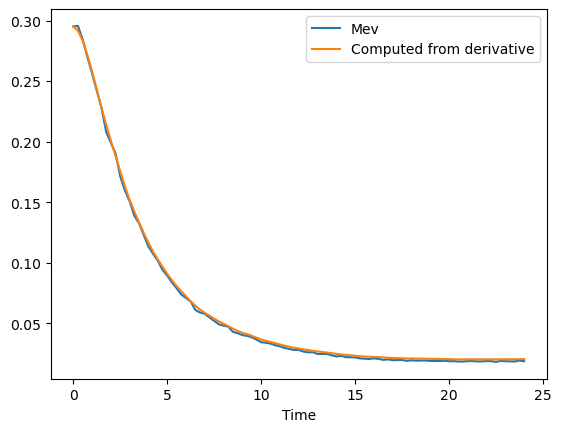

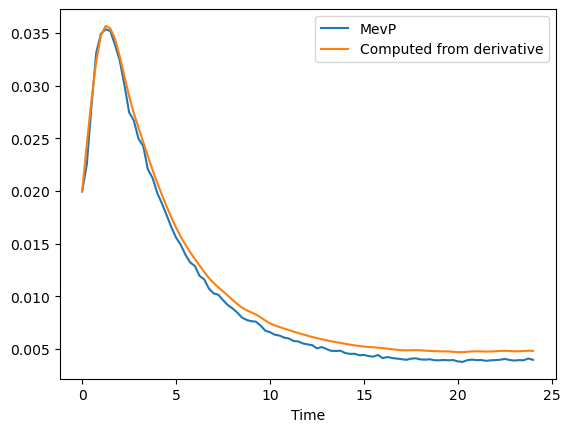

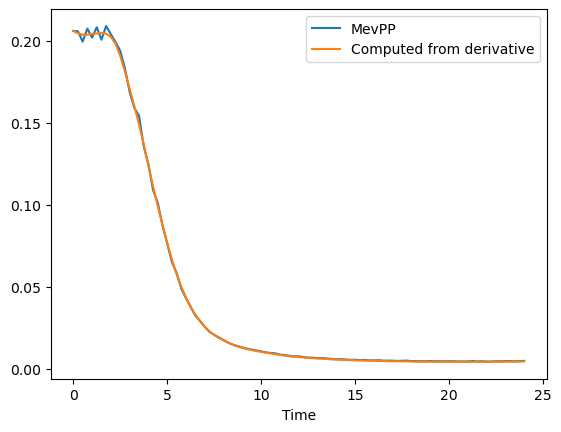

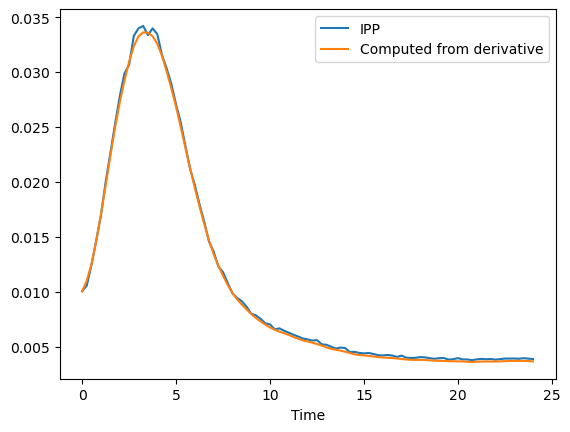

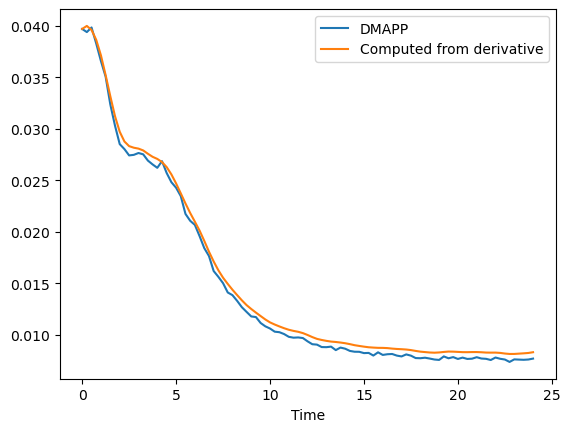

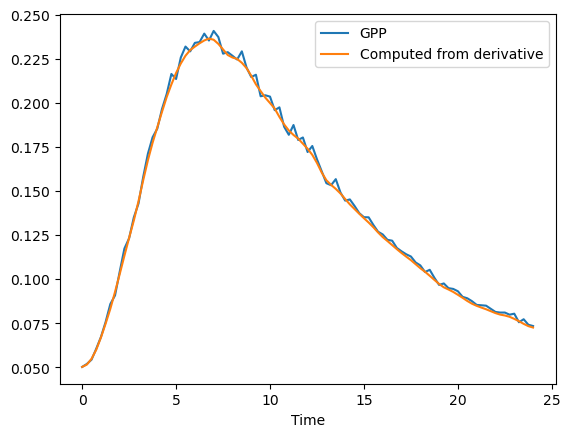

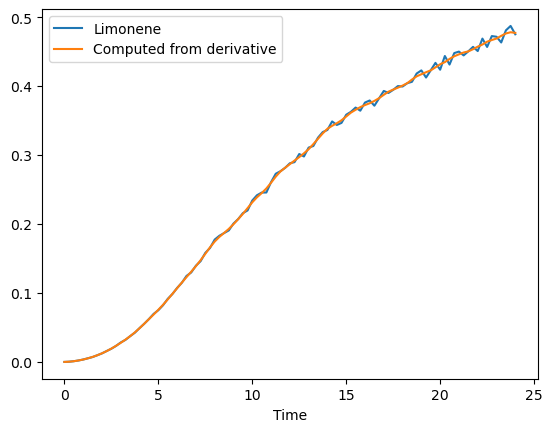

'Time profile from derivative vs. actual profile for WT'

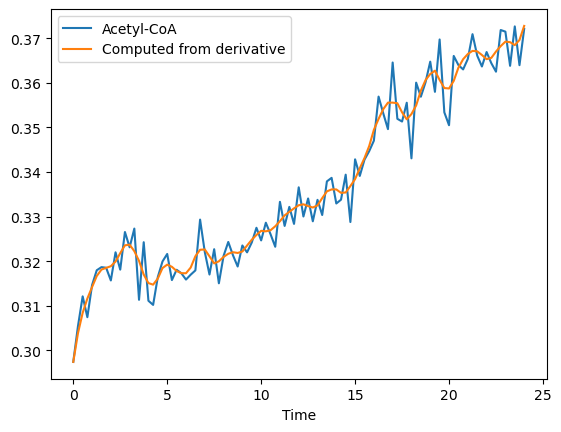

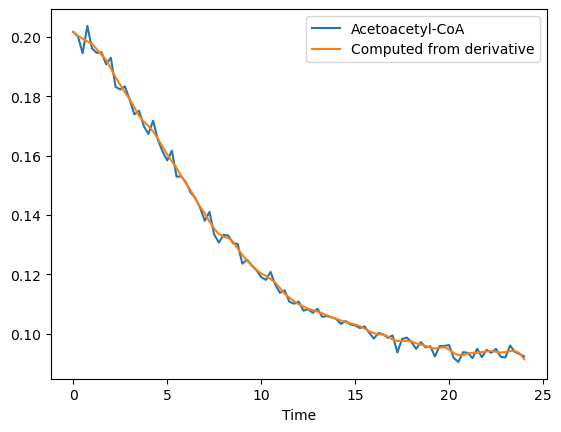

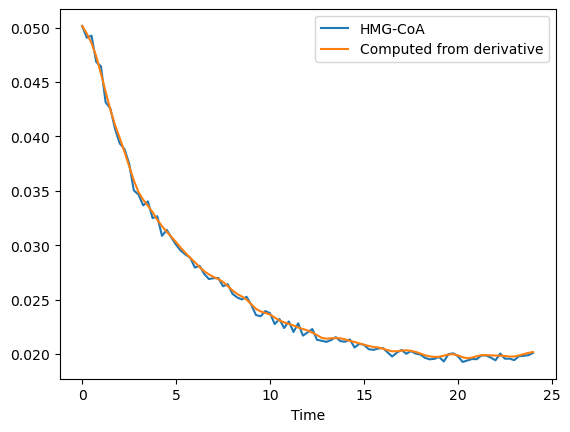

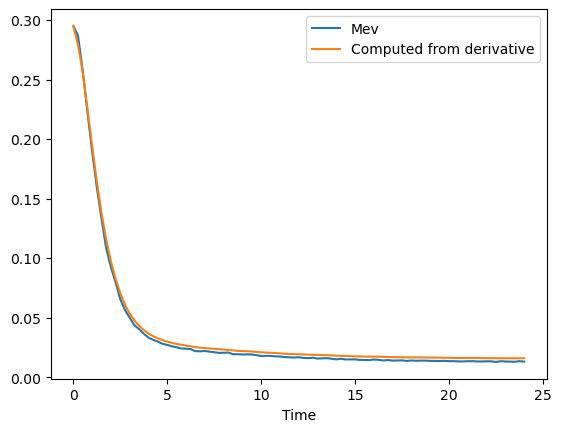

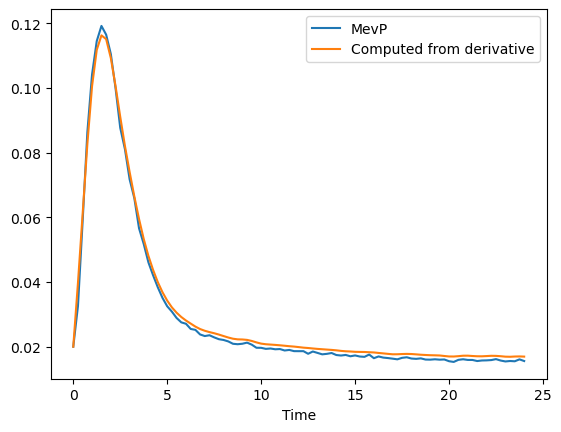

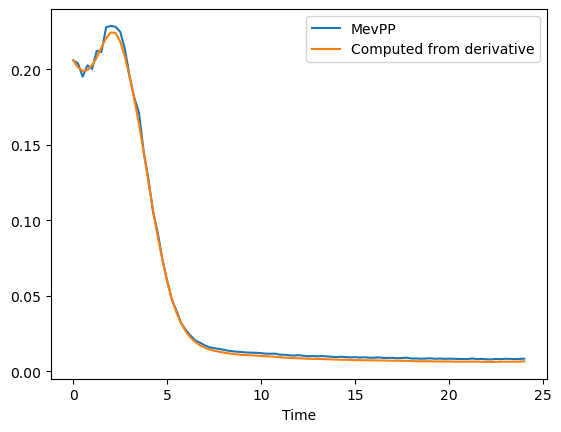

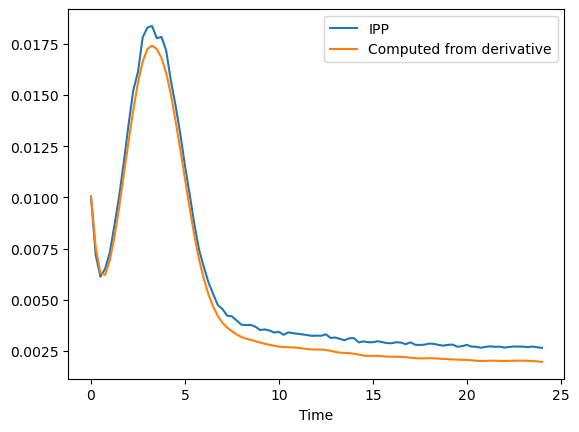

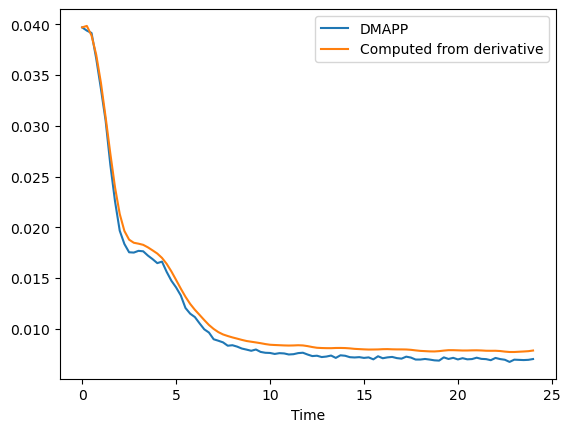

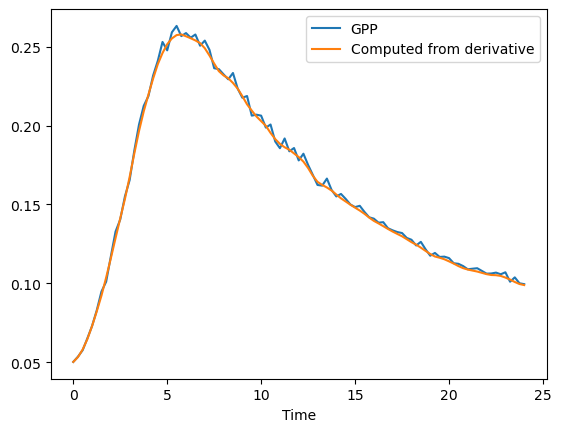

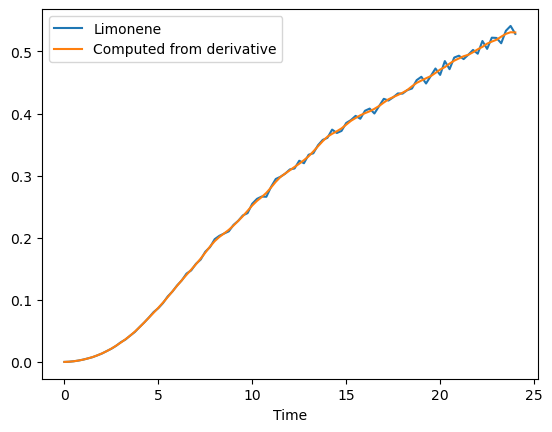

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.895904e+01  4.006396e+01  3.708489e+01  5.668387e+01   
         0.25   4.619542e+06  2.317008e+06  2.160956e+05  1.398457e+06   
         0.50   5.512627e+06  3.556799e+06  3.385569e+05  2.153234e+06   
         0.75   5.929421e+06  4.100638e+06  4.201464e+05  2.663142e+06   
         1.00   5.939704e+06  4.650100e+06  4.739500e+05  3.042015e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.713909e+06  2.632876e+06  1.768712e+06  2.006850e+06   
         23.25  2.748672e+06  2.663635e+06  1.787678e+06  2.019082e+06   
         23.50  2.713428e+06  2.759470e+06  1.739231e+06  2.027699e+06   
         23.75  2.820893e+06  2.699809e+06  1.789693e+06  2.003403e+06   
         24.00  2.690745e+06  2.634564e+06  1.765057e+06  2.028786e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.652667e+01  5.609052e+01  5.574226e+01  1.854788e+01   
         0.25   4.733219e+05  2.255882e+06  2.681733e+06  4.347550e+05   
         0.50   7.349474e+05  3.745038e+06  3.244573e+06  6.404414e+05   
         0.75   8.987189e+05  4.746496e+06  3.532781e+06  7.774754e+05   
         1.00   9.753001e+05  5.461227e+06  3.825207e+06  8.426694e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.494655e+06  3.940687e+06  4.425821e+06  1.213425e+06   
         23.25  1.497491e+06  3.971669e+06  4.379524e+06  1.241157e+06   
         23.50  1.528124e+06  3.910251e+06  4.408977e+06  1.247393e+06   
         23.75  1.486258e+06  4.001348e+06  4.414003e+06  1.251412e+06   
         24.00  1.515767e+06  3.977775e+06  4.322492e+06  1.216404e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.045565e+01   0.297424        0.201680  0.050157   
         0.25       1.806722e+05   0.299425        0.200789  0.052951   
         0.50       2.877380e+05   0.294721        0.194646  0.061848   
         0.75       3.644992e+05   0.277530        0.202127  0.069365   
         1.00       3.980958e+05   0.270379        0.192059  0.080348   
...                          ...        ...             ...       ...   
WT       23.00      1.432944e+06   0.371463        0.091969  0.019446   
         23.25      1.445567e+06   0.363803        0.095999  0.019811   
         23.50      1.477006e+06   0.372636        0.093898  0.019842   
         23.75      1.458479e+06   0.363945        0.093143  0.019896   
         24.00      1.473737e+06   0.372087        0.092351  0.020105   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.295112  0.019945  0.205907  0.010049  0.039701  0.050189   
         0.25   0.264835  0.052532  0.198549  0.011440  0.039493  0.054518   
         0.50   0.195068  0.111537  0.181729  0.014475  0.039112  0.063956   
         0.75   0.127900  0.157772  0.181940  0.017021  0.036023  0.080898   
         1.00   0.079256  0.171356  0.172375  0.019937  0.032835  0.100350   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.013122  0.015384  0.008232  0.002718  0.006955  0.107019   
         23.25  0.013026  0.015522  0.008189  0.002692  0.006934  0.101022   
         23.50  0.012892  0.015438  0.008026  0.002724  0.006915 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.004795       -0.001757  0.013577 -0.188448  0.221252   
         0.25    -0.012800       -0.004460  0.022148 -0.207953  0.192239   
         0.50    -0.030395       -0.007162  0.030719 -0.227459  0.163225   
         0.75    -0.041734       -0.011562  0.033593 -0.219354  0.113709   
         1.00    -0.045839       -0.014013  0.033330 -0.162774  0.032755   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004909        0.000722  0.000303 -0.000040 -0.000583   
         23.25   -0.005838        0.001533  0.000411 -0.000071  0.000314   
         23.50    0.000556       -0.000837  0.000561  0.000056  0.000304   
         23.75    0.008602       -0.005579  0.000396  0.000092 -0.000055   
         24.00    0.016648       -0.010320  0.000231  0.000128 -0.000415   

                                                                      
                   MevPP       IPP     DMAPP       GPP      Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.047891  0.007218  0.003028  0.007538  9.063289e-07  
         0.25  -0.040680  0.008680 -0.001926  0.029110  9.504149e-04  
         0.50  -0.033469  0.010143 -0.006880  0.050681  1.899923e-03  
         0.75  -0.026654  0.012350 -0.009624  0.070129  2.967370e-03  
         1.00  -0.029971  0.013245 -0.010684  0.087272  4.020624e-03  
...                  ...       ...       ...       ...           ...  
WT       23.00 -0.000030 -0.000013  0.000057 -0.004306  1.974979e-02  
         23.25  0.000033 -0.000024  0.000148 -0.005856  1.977451e-02  
         23.50  0.000053 -0.000050  0.000050 -0.006409  1.639770e-02  
         23.75  0.000446 -0.000091  0.000188 -0.003908  4.512148e-03  
         24.00  0.000838 -0.000133  0.000325 -0.001407 -7.373403e-03  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  5.528885E+36 |  1.681613E+14
     2 |      128 |  5.329366E+35 |  1.732820E+06
     3 |      192 |  5.301945E+35 |  1.053981E+03
     4 |      256 |  6.347602E+31 |  2.037036E+02
     5 |      320 |  5.228334E+24 |  3.751486E+01
     6 |      384 |  5.228334E+24 |  3.384437E+01
     7 |      448 |  4.764633E+02 |  2.935206E+01
     8 |      512 |  9.620339E+01 |  2.685696E+01
     9 |      576 |  4.094583E+01 |  2.606306E+01
    10 |      640 |  3.672137E+01 |  2.464617E+01
    11 |      704 |  2.513390E+01 |  2.403776E+01
    12 |      768 |  2.446204E+01 |  2.380103E+01
    13 |      832 |  2.416459E+01 |  2.374635E+01
    14 |      896 |  2.384521E+01 |  2.372046E+01
    15 |      960 |  2.375253E+01 |  2.370923E+01
    16 |     1024 |  2.373059E+01 |  2.370513E+01
    17 |     1088 |  2.370821E+01 |  2.369719E+01
    18 |     1152 |  2.368632E+01 |  2.364280E+01
    19 |     1216 |  2.36

   162 |    10368 |  1.106225E+01 |  1.105670E+01
   163 |    10432 |  1.106018E+01 |  1.105561E+01
   164 |    10496 |  1.105809E+01 |  1.105483E+01
   165 |    10560 |  1.105665E+01 |  1.105357E+01
   166 |    10624 |  1.105524E+01 |  1.105252E+01
   167 |    10688 |  1.105336E+01 |  1.105034E+01
   168 |    10752 |  1.105030E+01 |  1.104619E+01
   169 |    10816 |  1.104772E+01 |  1.104439E+01
   170 |    10880 |  1.104590E+01 |  1.104335E+01
   171 |    10944 |  1.104379E+01 |  1.104152E+01
   172 |    11008 |  1.104095E+01 |  1.103762E+01
   173 |    11072 |  1.103708E+01 |  1.103026E+01
   174 |    11136 |  1.103364E+01 |  1.102325E+01
   175 |    11200 |  1.101546E+01 |  1.096549E+01
   176 |    11264 |  1.088065E+01 |  1.063170E+01
   177 |    11328 |  1.070174E+01 |  1.043658E+01
   178 |    11392 |  1.048279E+01 |  1.014273E+01
   179 |    11456 |  1.022704E+01 |  1.000009E+01
   180 |    11520 |  1.007538E+01 |  9.8623192383
   181 |    11584 |  9.9073606944 |  9.6897482598


   326 |    20864 |  8.6270340218 |  8.4782624847
   327 |    20928 |  8.4941535765 |  8.3364017966
   328 |    20992 |  8.3361871897 |  8.0942691639
   329 |    21056 |  8.1095342482 |  7.8218016701
   330 |    21120 |  7.8873087329 |  7.6308355097
   331 |    21184 |  7.7203798812 |  7.5677462902
   332 |    21248 |  7.6347391242 |  7.5500808754
   333 |    21312 |  7.5692150399 |  7.5055912653
   334 |    21376 |  7.5260100834 |  7.4384066748
   335 |    21440 |  7.4664439741 |  7.4098454785
   336 |    21504 |  7.4109338100 |  7.3544252623
   337 |    21568 |  7.3720167484 |  7.3385488495
   338 |    21632 |  7.3462455272 |  7.3247962299
   339 |    21696 |  7.3261428264 |  7.3044035720
   340 |    21760 |  7.3069170366 |  7.2803268291
   341 |    21824 |  7.2869885438 |  7.2501075449
   342 |    21888 |  7.2540672068 |  7.2267246496
   343 |    21952 |  7.2355606170 |  7.2032969902
   344 |    22016 |  7.2104042811 |  7.1816238598
   345 |    22080 |  7.1787650236 |  7.1471708264


   490 |    31360 |  4.1724799749 |  4.1708049257
   491 |    31424 |  4.1712566620 |  4.1696150288
   492 |    31488 |  4.1699687476 |  4.1684133919
   493 |    31552 |  4.1683679050 |  4.1668055667
   494 |    31616 |  4.1670279313 |  4.1654238188
   495 |    31680 |  4.1656165583 |  4.1639641802
   496 |    31744 |  4.1636453387 |  4.1609273804
   497 |    31808 |  4.1626532755 |  4.1607043003
   498 |    31872 |  4.1614056809 |  4.1594777983
   499 |    31936 |  4.1595228768 |  4.1573617851
   500 |    32000 |  4.1578895017 |  4.1568196920
   501 |    32064 |  4.1567559300 |  4.1555729175
   502 |    32128 |  4.1558906573 |  4.1550328885
   503 |    32192 |  4.1550465374 |  4.1539487395
   504 |    32256 |  4.1511381085 |  4.1403771528
   505 |    32320 |  4.1431540561 |  4.1351816543
   506 |    32384 |  4.1348037294 |  4.1240801389
   507 |    32448 |  4.1270752588 |  4.1198413212
   508 |    32512 |  4.1211503644 |  4.1156774039
   509 |    32576 |  4.1159638909 |  4.1131298337


   654 |    41856 |  4.0649539209 |  4.0649050085
   655 |    41920 |  4.0649058935 |  4.0648600996
   656 |    41984 |  4.0648570079 |  4.0647881293
   657 |    42048 |  4.0648073961 |  4.0647509243
   658 |    42112 |  4.0647567496 |  4.0646523003
   659 |    42176 |  4.0646721544 |  4.0645975686
   660 |    42240 |  4.0646045092 |  4.0645509855
   661 |    42304 |  4.0645699272 |  4.0645111983
   662 |    42368 |  4.0645236659 |  4.0644839292
   663 |    42432 |  4.0644836042 |  4.0644487293
   664 |    42496 |  4.0644508516 |  4.0644052316
   665 |    42560 |  4.0644081659 |  4.0643720039
   666 |    42624 |  4.0643735513 |  4.0643250390
   667 |    42688 |  4.0643378247 |  4.0642770013
   668 |    42752 |  4.0642892073 |  4.0642144764
   669 |    42816 |  4.0642365050 |  4.0641713017
   670 |    42880 |  4.0641867178 |  4.0641329322
   671 |    42944 |  4.0641384435 |  4.0640863021
   672 |    43008 |  4.0640887328 |  4.0640143252
   673 |    43072 |  4.0640213131 |  4.0639710524


   818 |    52352 |  4.0604069091 |  4.0603835095
   819 |    52416 |  4.0603941146 |  4.0603731937
   820 |    52480 |  4.0603774798 |  4.0603560886
   821 |    52544 |  4.0603613001 |  4.0603376262
   822 |    52608 |  4.0603421623 |  4.0603260153
   823 |    52672 |  4.0603314297 |  4.0603234585
   824 |    52736 |  4.0603245015 |  4.0603165069
   825 |    52800 |  4.0603186621 |  4.0603097186
   826 |    52864 |  4.0603122612 |  4.0603047184
   827 |    52928 |  4.0603058105 |  4.0603001896
   828 |    52992 |  4.0603000001 |  4.0602966896
   829 |    53056 |  4.0602962108 |  4.0602915902
   830 |    53120 |  4.0602918223 |  4.0602858166
   831 |    53184 |  4.0602861386 |  4.0602781307
   832 |    53248 |  4.0602803061 |  4.0602729183
   833 |    53312 |  4.0602752859 |  4.0602675960
   834 |    53376 |  4.0602676189 |  4.0602570275
   835 |    53440 |  4.0602589766 |  4.0602516169
   836 |    53504 |  4.0602528888 |  4.0602481270
   837 |    53568 |  4.0602494261 |  4.0602436369


   982 |    62848 |  4.0551513221 |  4.0551487848
   983 |    62912 |  4.0551492299 |  4.0551468576
   984 |    62976 |  4.0551473883 |  4.0551449610
   985 |    63040 |  4.0551457800 |  4.0551436390
   986 |    63104 |  4.0551444378 |  4.0551424654
   987 |    63168 |  4.0551431277 |  4.0551420066
   988 |    63232 |  4.0551424051 |  4.0551413288
   989 |    63296 |  4.0551415704 |  4.0551408912
   990 |    63360 |  4.0551410735 |  4.0551405846
   991 |    63424 |  4.0551406906 |  4.0551402645
   992 |    63488 |  4.0551404764 |  4.0551399879
   993 |    63552 |  4.0551401219 |  4.0551395854
   994 |    63616 |  4.0551397516 |  4.0551391526
   995 |    63680 |  4.0551393066 |  4.0551388037
   996 |    63744 |  4.0551390532 |  4.0551385131
   997 |    63808 |  4.0551387559 |  4.0551383078
   998 |    63872 |  4.0551384175 |  4.0551381398
   999 |    63936 |  4.0551382138 |  4.0551378877
  1000 |    64000 |  4.0551379870 |  4.0551376158
  1001 |    64064 |  4.0551377582 |  4.0551375073


  1146 |    73344 |  4.0550779857 |  4.0550773965
  1147 |    73408 |  4.0550774195 |  4.0550766546
  1148 |    73472 |  4.0550767904 |  4.0550761331
  1149 |    73536 |  4.0550763659 |  4.0550758992
  1150 |    73600 |  4.0550759882 |  4.0550757634
  1151 |    73664 |  4.0550757685 |  4.0550755471
  1152 |    73728 |  4.0550755804 |  4.0550753832
  1153 |    73792 |  4.0550667830 |  4.0550365471
  1154 |    73856 |  4.0550447942 |  4.0550193027
  1155 |    73920 |  4.0550200842 |  4.0549899071
  1156 |    73984 |  4.0549965442 |  4.0549734917
  1157 |    74048 |  4.0549761904 |  4.0549594194
  1158 |    74112 |  4.0549632531 |  4.0549504965
  1159 |    74176 |  4.0549499400 |  4.0549412860
  1160 |    74240 |  4.0549437378 |  4.0549337036
  1161 |    74304 |  4.0549368413 |  4.0549239349
  1162 |    74368 |  4.0549296077 |  4.0549169730
  1163 |    74432 |  4.0549201561 |  4.0549085295
  1164 |    74496 |  4.0549095146 |  4.0549011894
  1165 |    74560 |  4.0549011090 |  4.0548935674


  1310 |    83840 |  4.0547585900 |  4.0547585121
  1311 |    83904 |  4.0547585314 |  4.0547584312
  1312 |    83968 |  4.0547584542 |  4.0547583819
  1313 |    84032 |  4.0547583999 |  4.0547583393
  1314 |    84096 |  4.0547583630 |  4.0547582965
  1315 |    84160 |  4.0547583133 |  4.0547582249
  1316 |    84224 |  4.0547582438 |  4.0547581288
  1317 |    84288 |  4.0547581445 |  4.0547580523
  1318 |    84352 |  4.0547580602 |  4.0547579691
  1319 |    84416 |  4.0547579642 |  4.0547578734
  1320 |    84480 |  4.0547578689 |  4.0547577399
  1321 |    84544 |  4.0547577717 |  4.0547576650
  1322 |    84608 |  4.0547576498 |  4.0547574960
  1323 |    84672 |  4.0547575090 |  4.0547573515
  1324 |    84736 |  4.0547573316 |  4.0547571380
  1325 |    84800 |  4.0547571826 |  4.0547569837
  1326 |    84864 |  4.0547569629 |  4.0547566815
  1327 |    84928 |  4.0547567060 |  4.0547564260
  1328 |    84992 |  4.0547563246 |  4.0547558979
  1329 |    85056 |  4.0547559293 |  4.0547554079


  1474 |    94336 |  4.0543049495 |  4.0543048437
  1475 |    94400 |  4.0543048879 |  4.0543047858
  1476 |    94464 |  4.0543048223 |  4.0543047266
  1477 |    94528 |  4.0543047617 |  4.0543046415
  1478 |    94592 |  4.0543046374 |  4.0543044656
  1479 |    94656 |  4.0543044632 |  4.0543042725
  1480 |    94720 |  4.0543043075 |  4.0543041778
  1481 |    94784 |  4.0543041939 |  4.0543040737
  1482 |    94848 |  4.0543041177 |  4.0543040371
  1483 |    94912 |  4.0543040366 |  4.0543039585
  1484 |    94976 |  4.0543039714 |  4.0543039043
  1485 |    95040 |  4.0543039205 |  4.0543038522
  1486 |    95104 |  4.0543038534 |  4.0543038035
  1487 |    95168 |  4.0543038151 |  4.0543037837
  1488 |    95232 |  4.0543037966 |  4.0543037754
  1489 |    95296 |  4.0543037813 |  4.0543037582
  1490 |    95360 |  4.0543037573 |  4.0543037312
  1491 |    95424 |  4.0543037333 |  4.0543037049
  1492 |    95488 |  4.0543037159 |  4.0543036971
  1493 |    95552 |  4.0543037021 |  4.0543036845


  1638 |   104832 |  4.0542230688 |  4.0542230652
  1639 |   104896 |  4.0542230667 |  4.0542230633
  1640 |   104960 |  4.0542230644 |  4.0542230624
  1641 |   105024 |  4.0542230632 |  4.0542230612
  1642 |   105088 |  4.0542230618 |  4.0542230606
  1643 |   105152 |  4.0542230608 |  4.0542230600
  1644 |   105216 |  4.0542230602 |  4.0542230596
  1645 |   105280 |  4.0542230597 |  4.0542230588
  1646 |   105344 |  4.0542230589 |  4.0542230583
  1647 |   105408 |  4.0542230585 |  4.0542230578
  1648 |   105472 |  4.0542230581 |  4.0542230577
  1649 |   105536 |  4.0542230576 |  4.0542230567
  1650 |   105600 |  4.0542230567 |  4.0542230548
  1651 |   105664 |  4.0542230547 |  4.0542230521
  1652 |   105728 |  4.0542230525 |  4.0542230503
  1653 |   105792 |  4.0542030152 |  4.0541823794
  1654 |   105856 |  4.0541909146 |  4.0541823372
  1655 |   105920 |  4.0541850573 |  4.0541821618
  1656 |   105984 |  4.0541828257 |  4.0541779080
  1657 |   106048 |  4.0541759017 |  4.0541673212


  1802 |   115328 |  4.0541339058 |  4.0541338973
  1803 |   115392 |  4.0541338973 |  4.0541338872
  1804 |   115456 |  4.0541338905 |  4.0541338845
  1805 |   115520 |  4.0541338862 |  4.0541338823
  1806 |   115584 |  4.0541338830 |  4.0541338797
  1807 |   115648 |  4.0541338799 |  4.0541338766
  1808 |   115712 |  4.0541338774 |  4.0541338741
  1809 |   115776 |  4.0541338745 |  4.0541338709
  1810 |   115840 |  4.0541338720 |  4.0541338686
  1811 |   115904 |  4.0541338689 |  4.0541338661
  1812 |   115968 |  4.0541338668 |  4.0541338644
  1813 |   116032 |  4.0541338648 |  4.0541338619
  1814 |   116096 |  4.0541338607 |  4.0541338555
  1815 |   116160 |  4.0541338562 |  4.0541338511
  1816 |   116224 |  4.0541338511 |  4.0541338460
  1817 |   116288 |  4.0541338466 |  4.0541338437
  1818 |   116352 |  4.0541338428 |  4.0541338360
  1819 |   116416 |  4.0541338365 |  4.0541338312
  1820 |   116480 |  4.0541338309 |  4.0541338243
  1821 |   116544 |  4.0541338259 |  4.0541338195


  1966 |   125824 |  4.0541289167 |  4.0541289146
  1967 |   125888 |  4.0541289150 |  4.0541289120
  1968 |   125952 |  4.0541289123 |  4.0541289097
  1969 |   126016 |  4.0541289100 |  4.0541289075
  1970 |   126080 |  4.0541289072 |  4.0541289038
  1971 |   126144 |  4.0541289043 |  4.0541289012
  1972 |   126208 |  4.0541289022 |  4.0541288993
  1973 |   126272 |  4.0541289004 |  4.0541288983
  1974 |   126336 |  4.0541288993 |  4.0541288976
  1975 |   126400 |  4.0541288979 |  4.0541288969
  1976 |   126464 |  4.0541288972 |  4.0541288965
  1977 |   126528 |  4.0541288967 |  4.0541288960
  1978 |   126592 |  4.0541288962 |  4.0541288958
  1979 |   126656 |  4.0541288959 |  4.0541288956
  1980 |   126720 |  4.0541288956 |  4.0541288952
  1981 |   126784 |  4.0541288953 |  4.0541288947
  1982 |   126848 |  4.0541288945 |  4.0541288932
  1983 |   126912 |  4.0541288931 |  4.0541288917
  1984 |   126976 |  4.0541288919 |  4.0541288905
  1985 |   127040 |  4.0541288904 |  4.0541288891


  2130 |   136320 |  4.0541238222 |  4.0541238093
  2131 |   136384 |  4.0541238082 |  4.0541237920
  2132 |   136448 |  4.0541237975 |  4.0541237871
  2133 |   136512 |  4.0541237901 |  4.0541237791
  2134 |   136576 |  4.0541237837 |  4.0541237695
  2135 |   136640 |  4.0541237736 |  4.0541237658
  2136 |   136704 |  4.0541237673 |  4.0541237610
  2137 |   136768 |  4.0541237628 |  4.0541237604
  2138 |   136832 |  4.0541237605 |  4.0541237591
  2139 |   136896 |  4.0541237595 |  4.0541237583
  2140 |   136960 |  4.0541237589 |  4.0541237578
  2141 |   137024 |  4.0541237581 |  4.0541237574
  2142 |   137088 |  4.0541237576 |  4.0541237568
  2143 |   137152 |  4.0541160548 |  4.0541080710
  2144 |   137216 |  4.0541109915 |  4.0541080694
  2145 |   137280 |  4.0541097079 |  4.0541080333
  2146 |   137344 |  4.0541088970 |  4.0541065572
  2147 |   137408 |  4.0541050392 |  4.0541003624
  2148 |   137472 |  4.0541012456 |  4.0540968588
  2149 |   137536 |  4.0540978202 |  4.0540943514


  2294 |   146816 |  4.0539886869 |  4.0539877496
  2295 |   146880 |  4.0539881532 |  4.0539873852
  2296 |   146944 |  4.0539874597 |  4.0539866797
  2297 |   147008 |  4.0539869459 |  4.0539864887
  2298 |   147072 |  4.0539865938 |  4.0539862020
  2299 |   147136 |  4.0539862989 |  4.0539860971
  2300 |   147200 |  4.0539861831 |  4.0539859695
  2301 |   147264 |  4.0539860377 |  4.0539858916
  2302 |   147328 |  4.0539859453 |  4.0539858398
  2303 |   147392 |  4.0539858889 |  4.0539858062
  2304 |   147456 |  4.0539858358 |  4.0539857605
  2305 |   147520 |  4.0539858010 |  4.0539857350
  2306 |   147584 |  4.0539857512 |  4.0539857038
  2307 |   147648 |  4.0539857217 |  4.0539856816
  2308 |   147712 |  4.0539856940 |  4.0539856534
  2309 |   147776 |  4.0539856660 |  4.0539856292
  2310 |   147840 |  4.0539856396 |  4.0539856074
  2311 |   147904 |  4.0539856207 |  4.0539855889
  2312 |   147968 |  4.0539855972 |  4.0539855772
  2313 |   148032 |  4.0539855802 |  4.0539855519


  2458 |   157312 |  4.0539809047 |  4.0539808842
  2459 |   157376 |  4.0539808865 |  4.0539808838
  2460 |   157440 |  4.0539808841 |  4.0539808834
  2461 |   157504 |  4.0539808838 |  4.0539808832
  2462 |   157568 |  4.0539808833 |  4.0539808828
  2463 |   157632 |  4.0539808828 |  4.0539808821
  2464 |   157696 |  4.0539808822 |  4.0539808812
  2465 |   157760 |  4.0539808813 |  4.0539808799
  2466 |   157824 |  4.0539808800 |  4.0539808783
  2467 |   157888 |  4.0539808787 |  4.0539808774
  2468 |   157952 |  4.0539808779 |  4.0539808767
  2469 |   158016 |  4.0539808768 |  4.0539808749
  2470 |   158080 |  4.0539808755 |  4.0539808732
  2471 |   158144 |  4.0539808737 |  4.0539808711
  2472 |   158208 |  4.0539808712 |  4.0539808680
  2473 |   158272 |  4.0539808692 |  4.0539808659
  2474 |   158336 |  4.0539808671 |  4.0539808637
  2475 |   158400 |  4.0539808639 |  4.0539808607
  2476 |   158464 |  4.0539808616 |  4.0539808585
  2477 |   158528 |  4.0539808597 |  4.0539808565


  2622 |   167808 |  4.0539662585 |  4.0539635573
  2623 |   167872 |  4.0539646654 |  4.0539632802
  2624 |   167936 |  4.0539632821 |  4.0539612281
  2625 |   168000 |  4.0539613672 |  4.0539596017
  2626 |   168064 |  4.0539590355 |  4.0539563905
  2627 |   168128 |  4.0539570648 |  4.0539533775
  2628 |   168192 |  4.0539539177 |  4.0539493265
  2629 |   168256 |  4.0539503385 |  4.0539464832
  2630 |   168320 |  4.0539469181 |  4.0539427349
  2631 |   168384 |  4.0539445334 |  4.0539416726
  2632 |   168448 |  4.0539424373 |  4.0539410587
  2633 |   168512 |  4.0539412314 |  4.0539400558
  2634 |   168576 |  4.0539397699 |  4.0539374957
  2635 |   168640 |  4.0539379110 |  4.0539358962
  2636 |   168704 |  4.0539358164 |  4.0539337858
  2637 |   168768 |  4.0539344620 |  4.0539323620
  2638 |   168832 |  4.0539326603 |  4.0539310733
  2639 |   168896 |  4.0539313508 |  4.0539291059
  2640 |   168960 |  4.0539300234 |  4.0539284376
  2641 |   169024 |  4.0539289165 |  4.0539277780


  2786 |   178304 |  4.0538922010 |  4.0538914074
  2787 |   178368 |  4.0538914630 |  4.0538906837
  2788 |   178432 |  4.0538906188 |  4.0538899115
  2789 |   178496 |  4.0538901921 |  4.0538899107
  2790 |   178560 |  4.0538900115 |  4.0538899104
  2791 |   178624 |  4.0538899241 |  4.0538899094
  2792 |   178688 |  4.0538899228 |  4.0538899073
  2793 |   178752 |  4.0538899077 |  4.0538899046
  2794 |   178816 |  4.0538899049 |  4.0538899007
  2795 |   178880 |  4.0538899018 |  4.0538898975
  2796 |   178944 |  4.0538898971 |  4.0538898915
  2797 |   179008 |  4.0538898923 |  4.0538898863
  2798 |   179072 |  4.0538898863 |  4.0538898786
  2799 |   179136 |  4.0538898799 |  4.0538898744
  2800 |   179200 |  4.0538898755 |  4.0538898686
  2801 |   179264 |  4.0538898694 |  4.0538898619
  2802 |   179328 |  4.0538898639 |  4.0538898576
  2803 |   179392 |  4.0538898570 |  4.0538898487
  2804 |   179456 |  4.0538898453 |  4.0538898222
  2805 |   179520 |  4.0538898232 |  4.0538897977


  2950 |   188800 |  4.0538555892 |  4.0538553656
  2951 |   188864 |  4.0538553930 |  4.0538551837
  2952 |   188928 |  4.0538552237 |  4.0538550986
  2953 |   188992 |  4.0538551572 |  4.0538550512
  2954 |   189056 |  4.0538550365 |  4.0538549349
  2955 |   189120 |  4.0538549611 |  4.0538548843
  2956 |   189184 |  4.0538549000 |  4.0538548171
  2957 |   189248 |  4.0538548295 |  4.0538547646
  2958 |   189312 |  4.0538547772 |  4.0538547229
  2959 |   189376 |  4.0538547303 |  4.0538546729
  2960 |   189440 |  4.0538546883 |  4.0538546365
  2961 |   189504 |  4.0538546319 |  4.0538545777
  2962 |   189568 |  4.0538545783 |  4.0538545290
  2963 |   189632 |  4.0538545312 |  4.0538544694
  2964 |   189696 |  4.0538544797 |  4.0538544325
  2965 |   189760 |  4.0538544294 |  4.0538543807
  2966 |   189824 |  4.0538543891 |  4.0538543555
  2967 |   189888 |  4.0538543452 |  4.0538542964
  2968 |   189952 |  4.0538543085 |  4.0538542696
  2969 |   190016 |  4.0538542752 |  4.0538542301


  3114 |   199296 |  4.0538316205 |  4.0538316198
  3115 |   199360 |  4.0538316199 |  4.0538316193
  3116 |   199424 |  4.0538316194 |  4.0538316190
  3117 |   199488 |  4.0538316192 |  4.0538316189
  3118 |   199552 |  4.0538316190 |  4.0538316187
  3119 |   199616 |  4.0538316188 |  4.0538316185
  3120 |   199680 |  4.0538316185 |  4.0538316182
  3121 |   199744 |  4.0538316184 |  4.0538316181
  3122 |   199808 |  4.0538316182 |  4.0538316179
  3123 |   199872 |  4.0538316179 |  4.0538316174
  3124 |   199936 |  4.0538316176 |  4.0538316172
  3125 |   200000 |  4.0538316173 |  4.0538316170
  3126 |   200064 |  4.0538316171 |  4.0538316166
  3127 |   200128 |  4.0538316167 |  4.0538316160
  3128 |   200192 |  4.0538316162 |  4.0538316156
  3129 |   200256 |  4.0538300978 |  4.0538269020
  3130 |   200320 |  4.0538283339 |  4.0538268165
  3131 |   200384 |  4.0538271295 |  4.0538264102
  3132 |   200448 |  4.0538264300 |  4.0538252114
  3133 |   200512 |  4.0538253388 |  4.0538237192


  3278 |   209792 |  4.0538066849 |  4.0538066836
  3279 |   209856 |  4.0538066837 |  4.0538066815
  3280 |   209920 |  4.0538066821 |  4.0538066805
  3281 |   209984 |  4.0538066811 |  4.0538066795
  3282 |   210048 |  4.0538066799 |  4.0538066787
  3283 |   210112 |  4.0538066791 |  4.0538066782
  3284 |   210176 |  4.0538066781 |  4.0538066769
  3285 |   210240 |  4.0538066767 |  4.0538066753
  3286 |   210304 |  4.0538066759 |  4.0538066749
  3287 |   210368 |  4.0538066751 |  4.0538066741
  3288 |   210432 |  4.0538066738 |  4.0538066716
  3289 |   210496 |  4.0538066722 |  4.0538066699
  3290 |   210560 |  4.0538066706 |  4.0538066676
  3291 |   210624 |  4.0538066679 |  4.0538066646
  3292 |   210688 |  4.0538066648 |  4.0538066619
  3293 |   210752 |  4.0538066627 |  4.0538066608
  3294 |   210816 |  4.0538066612 |  4.0538066588
  3295 |   210880 |  4.0538066598 |  4.0538066578
  3296 |   210944 |  4.0538066579 |  4.0538066556
  3297 |   211008 |  4.0538066560 |  4.0538066542


  3442 |   220288 |  4.0536298041 |  4.0536275115
  3443 |   220352 |  4.0536285259 |  4.0536266849
  3444 |   220416 |  4.0536268164 |  4.0536249946
  3445 |   220480 |  4.0536256248 |  4.0536243989
  3446 |   220544 |  4.0536249517 |  4.0536238599
  3447 |   220608 |  4.0536243464 |  4.0536230882
  3448 |   220672 |  4.0536236282 |  4.0536229565
  3449 |   220736 |  4.0536230434 |  4.0536222516
  3450 |   220800 |  4.0536225292 |  4.0536219424
  3451 |   220864 |  4.0536219524 |  4.0536212287
  3452 |   220928 |  4.0536215440 |  4.0536209313
  3453 |   220992 |  4.0536212404 |  4.0536207206
  3454 |   221056 |  4.0536208929 |  4.0536205458
  3455 |   221120 |  4.0536206769 |  4.0536202484
  3456 |   221184 |  4.0536203948 |  4.0536199312
  3457 |   221248 |  4.0536200955 |  4.0536197061
  3458 |   221312 |  4.0536198187 |  4.0536195980
  3459 |   221376 |  4.0536196638 |  4.0536195294
  3460 |   221440 |  4.0536195738 |  4.0536194384
  3461 |   221504 |  4.0536194461 |  4.0536192190


  3606 |   230784 |  4.0535642121 |  4.0535641080
  3607 |   230848 |  4.0535641427 |  4.0535640294
  3608 |   230912 |  4.0535640734 |  4.0535639690
  3609 |   230976 |  4.0535639970 |  4.0535639154
  3610 |   231040 |  4.0535639115 |  4.0535637819
  3611 |   231104 |  4.0535638192 |  4.0535637152
  3612 |   231168 |  4.0535637412 |  4.0535636520
  3613 |   231232 |  4.0535636807 |  4.0535636189
  3614 |   231296 |  4.0535636372 |  4.0535636014
  3615 |   231360 |  4.0535636104 |  4.0535635628
  3616 |   231424 |  4.0535635526 |  4.0535634547
  3617 |   231488 |  4.0535634959 |  4.0535634120
  3618 |   231552 |  4.0535634416 |  4.0535633844
  3619 |   231616 |  4.0535634034 |  4.0535633647
  3620 |   231680 |  4.0535633657 |  4.0535633210
  3621 |   231744 |  4.0535633348 |  4.0535632996
  3622 |   231808 |  4.0535633139 |  4.0535632852
  3623 |   231872 |  4.0535632819 |  4.0535632498
  3624 |   231936 |  4.0535632597 |  4.0535632344
  3625 |   232000 |  4.0535632423 |  4.0535632236


  3770 |   241280 |  4.0535396842 |  4.0535394725
  3771 |   241344 |  4.0535394522 |  4.0535391145
  3772 |   241408 |  4.0535391911 |  4.0535389801
  3773 |   241472 |  4.0535390235 |  4.0535387507
  3774 |   241536 |  4.0535388354 |  4.0535385535
  3775 |   241600 |  4.0535386149 |  4.0535382857
  3776 |   241664 |  4.0535383896 |  4.0535381655
  3777 |   241728 |  4.0535382401 |  4.0535381328
  3778 |   241792 |  4.0535381531 |  4.0535380894
  3779 |   241856 |  4.0535381035 |  4.0535380204
  3780 |   241920 |  4.0535380498 |  4.0535380043
  3781 |   241984 |  4.0535380184 |  4.0535379729
  3782 |   242048 |  4.0535379834 |  4.0535379533
  3783 |   242112 |  4.0535379601 |  4.0535379333
  3784 |   242176 |  4.0535379457 |  4.0535379256
  3785 |   242240 |  4.0535379305 |  4.0535379101
  3786 |   242304 |  4.0535379098 |  4.0535378770
  3787 |   242368 |  4.0535378812 |  4.0535378451
  3788 |   242432 |  4.0535378527 |  4.0535378209
  3789 |   242496 |  4.0535378323 |  4.0535378043


  3934 |   251776 |  4.0535210292 |  4.0535210098
  3935 |   251840 |  4.0535210153 |  4.0535209884
  3936 |   251904 |  4.0535209951 |  4.0535209754
  3937 |   251968 |  4.0535209819 |  4.0535209660
  3938 |   252032 |  4.0535209693 |  4.0535209551
  3939 |   252096 |  4.0535209595 |  4.0535209469
  3940 |   252160 |  4.0535209432 |  4.0535209196
  3941 |   252224 |  4.0535209238 |  4.0535209045
  3942 |   252288 |  4.0535209084 |  4.0535208902
  3943 |   252352 |  4.0535208959 |  4.0535208805
  3944 |   252416 |  4.0535208842 |  4.0535208707
  3945 |   252480 |  4.0535208742 |  4.0535208634
  3946 |   252544 |  4.0535208665 |  4.0535208585
  3947 |   252608 |  4.0535208596 |  4.0535208538
  3948 |   252672 |  4.0535208557 |  4.0535208498
  3949 |   252736 |  4.0535208521 |  4.0535208469
  3950 |   252800 |  4.0535208489 |  4.0535208432
  3951 |   252864 |  4.0535208460 |  4.0535208403
  3952 |   252928 |  4.0535208417 |  4.0535208369
  3953 |   252992 |  4.0535208375 |  4.0535208316


  4098 |   262272 |  4.0534275121 |  4.0534274726
  4099 |   262336 |  4.0534274816 |  4.0534274650
  4100 |   262400 |  4.0534274692 |  4.0534274562
  4101 |   262464 |  4.0534274587 |  4.0534274488
  4102 |   262528 |  4.0534274498 |  4.0534274367
  4103 |   262592 |  4.0534274403 |  4.0534274256
  4104 |   262656 |  4.0534274294 |  4.0534274168
  4105 |   262720 |  4.0534274146 |  4.0534274025
  4106 |   262784 |  4.0534274054 |  4.0534273965
  4107 |   262848 |  4.0534273988 |  4.0534273888
  4108 |   262912 |  4.0534273908 |  4.0534273841
  4109 |   262976 |  4.0534273831 |  4.0534273718
  4110 |   263040 |  4.0534273744 |  4.0534273687
  4111 |   263104 |  4.0534273695 |  4.0534273646
  4112 |   263168 |  4.0534273660 |  4.0534273610
  4113 |   263232 |  4.0534273627 |  4.0534273578
  4114 |   263296 |  4.0534273586 |  4.0534273551
  4115 |   263360 |  4.0534273562 |  4.0534273536
  4116 |   263424 |  4.0534273540 |  4.0534273510
  4117 |   263488 |  4.0534273514 |  4.0534273494


  4262 |   272768 |  4.0534001019 |  4.0534000974
  4263 |   272832 |  4.0534000988 |  4.0534000930
  4264 |   272896 |  4.0534000953 |  4.0534000913
  4265 |   272960 |  4.0534000928 |  4.0534000885
  4266 |   273024 |  4.0534000906 |  4.0534000867
  4267 |   273088 |  4.0534000869 |  4.0534000823
  4268 |   273152 |  4.0534000836 |  4.0534000785
  4269 |   273216 |  4.0534000802 |  4.0534000757
  4270 |   273280 |  4.0534000776 |  4.0534000744
  4271 |   273344 |  4.0534000758 |  4.0534000723
  4272 |   273408 |  4.0534000732 |  4.0534000703
  4273 |   273472 |  4.0534000713 |  4.0534000680
  4274 |   273536 |  4.0534000688 |  4.0534000648
  4275 |   273600 |  4.0534000665 |  4.0534000625
  4276 |   273664 |  4.0534000631 |  4.0534000598
  4277 |   273728 |  4.0534000605 |  4.0534000580
  4278 |   273792 |  4.0534000584 |  4.0534000561
  4279 |   273856 |  4.0534000570 |  4.0534000556
  4280 |   273920 |  4.0534000558 |  4.0534000548
  4281 |   273984 |  4.0534000547 |  4.0534000534


  4426 |   283264 |  4.0533807063 |  4.0533804313
  4427 |   283328 |  4.0533805351 |  4.0533802717
  4428 |   283392 |  4.0533802642 |  4.0533799954
  4429 |   283456 |  4.0533800230 |  4.0533797819
  4430 |   283520 |  4.0533798675 |  4.0533797001
  4431 |   283584 |  4.0533796976 |  4.0533795833
  4432 |   283648 |  4.0533796204 |  4.0533795570
  4433 |   283712 |  4.0533795847 |  4.0533795295
  4434 |   283776 |  4.0533795491 |  4.0533795036
  4435 |   283840 |  4.0533795199 |  4.0533794679
  4436 |   283904 |  4.0533794876 |  4.0533794222
  4437 |   283968 |  4.0533794570 |  4.0533793837
  4438 |   284032 |  4.0533793765 |  4.0533792709
  4439 |   284096 |  4.0533792977 |  4.0533791922
  4440 |   284160 |  4.0533792278 |  4.0533791522
  4441 |   284224 |  4.0533791776 |  4.0533791199
  4442 |   284288 |  4.0533791412 |  4.0533790871
  4443 |   284352 |  4.0533791055 |  4.0533790516
  4444 |   284416 |  4.0533790244 |  4.0533789386
  4445 |   284480 |  4.0533789593 |  4.0533788828


  4590 |   293760 |  4.0533773597 |  4.0533773596
  4591 |   293824 |  4.0533773596 |  4.0533773594
  4592 |   293888 |  4.0533773594 |  4.0533773592
  4593 |   293952 |  4.0533773592 |  4.0533773590
  4594 |   294016 |  4.0533773590 |  4.0533773587
  4595 |   294080 |  4.0533773586 |  4.0533773582
  4596 |   294144 |  4.0533773582 |  4.0533773577
  4597 |   294208 |  4.0533773575 |  4.0533773564
  4598 |   294272 |  4.0533773561 |  4.0533773540
  4599 |   294336 |  4.0533773542 |  4.0533773513
  4600 |   294400 |  4.0533773508 |  4.0533773456
  4601 |   294464 |  4.0533773449 |  4.0533773328
  4602 |   294528 |  4.0533773271 |  4.0533772977
  4603 |   294592 |  4.0533772729 |  4.0533768784
  4604 |   294656 |  4.0533769830 |  4.0533766741
  4605 |   294720 |  4.0533768223 |  4.0533766351
  4606 |   294784 |  4.0533767181 |  4.0533765949
  4607 |   294848 |  4.0533766432 |  4.0533765094
  4608 |   294912 |  4.0533765424 |  4.0533764712
  4609 |   294976 |  4.0533764972 |  4.0533764201


  4754 |   304256 |  4.0532986453 |  4.0532986189
  4755 |   304320 |  4.0532986242 |  4.0532985976
  4756 |   304384 |  4.0532986065 |  4.0532985816
  4757 |   304448 |  4.0532985893 |  4.0532985633
  4758 |   304512 |  4.0532985718 |  4.0532985444
  4759 |   304576 |  4.0532985529 |  4.0532985293
  4760 |   304640 |  4.0532985405 |  4.0532985204
  4761 |   304704 |  4.0532985312 |  4.0532985147
  4762 |   304768 |  4.0532985201 |  4.0532985065
  4763 |   304832 |  4.0532985120 |  4.0532984981
  4764 |   304896 |  4.0532985036 |  4.0532984933
  4765 |   304960 |  4.0532984966 |  4.0532984862
  4766 |   305024 |  4.0532984898 |  4.0532984798
  4767 |   305088 |  4.0532984831 |  4.0532984753
  4768 |   305152 |  4.0532984777 |  4.0532984726
  4769 |   305216 |  4.0532984744 |  4.0532984702
  4770 |   305280 |  4.0532984688 |  4.0532984595
  4771 |   305344 |  4.0532984616 |  4.0532984542
  4772 |   305408 |  4.0532984568 |  4.0532984493
  4773 |   305472 |  4.0532984519 |  4.0532984415


  4918 |   314752 |  4.0532966845 |  4.0532966843
  4919 |   314816 |  4.0532966843 |  4.0532966840
  4920 |   314880 |  4.0532966840 |  4.0532966837
  4921 |   314944 |  4.0532966837 |  4.0532966833
  4922 |   315008 |  4.0532966834 |  4.0532966831
  4923 |   315072 |  4.0532966831 |  4.0532966829
  4924 |   315136 |  4.0532966829 |  4.0532966827
  4925 |   315200 |  4.0532966827 |  4.0532966826
  4926 |   315264 |  4.0532966826 |  4.0532966825
  4927 |   315328 |  4.0532966825 |  4.0532966822
  4928 |   315392 |  4.0532966822 |  4.0532966819
  4929 |   315456 |  4.0532966818 |  4.0532966809
  4930 |   315520 |  4.0532966807 |  4.0532966791
  4931 |   315584 |  4.0532966793 |  4.0532966775
  4932 |   315648 |  4.0532966776 |  4.0532966754
  4933 |   315712 |  4.0532966745 |  4.0532966694
  4934 |   315776 |  4.0532966665 |  4.0532966560
  4935 |   315840 |  4.0532966537 |  4.0532966372
  4936 |   315904 |  4.0532966345 |  4.0532966115
  4937 |   315968 |  4.0532966115 |  4.0532965810


  5082 |   325248 |  4.0532954718 |  4.0532954513
  5083 |   325312 |  4.0532954511 |  4.0532954125
  5084 |   325376 |  4.0532954212 |  4.0532953933
  5085 |   325440 |  4.0532953999 |  4.0532953622
  5086 |   325504 |  4.0532953638 |  4.0532953086
  5087 |   325568 |  4.0532953080 |  4.0532952459
  5088 |   325632 |  4.0532952530 |  4.0532952192
  5089 |   325696 |  4.0532952365 |  4.0532952183
  5090 |   325760 |  4.0532952263 |  4.0532952178
  5091 |   325824 |  4.0532952181 |  4.0532952160
  5092 |   325888 |  4.0532952169 |  4.0532952143
  5093 |   325952 |  4.0532952154 |  4.0532952130
  5094 |   326016 |  4.0532952138 |  4.0532952116
  5095 |   326080 |  4.0532952116 |  4.0532952078
  5096 |   326144 |  4.0532952087 |  4.0532952033
  5097 |   326208 |  4.0532952050 |  4.0532952019
  5098 |   326272 |  4.0532952035 |  4.0532952004
  5099 |   326336 |  4.0532952013 |  4.0532951986
  5100 |   326400 |  4.0532951991 |  4.0532951970
  5101 |   326464 |  4.0532951973 |  4.0532951944


  5246 |   335744 |  4.0532835909 |  4.0532834139
  5247 |   335808 |  4.0532834493 |  4.0532833463
  5248 |   335872 |  4.0532833880 |  4.0532833014
  5249 |   335936 |  4.0532833424 |  4.0532832586
  5250 |   336000 |  4.0532832683 |  4.0532831574
  5251 |   336064 |  4.0532832056 |  4.0532831026
  5252 |   336128 |  4.0532831231 |  4.0532830238
  5253 |   336192 |  4.0532830448 |  4.0532829235
  5254 |   336256 |  4.0532829675 |  4.0532828616
  5255 |   336320 |  4.0532828924 |  4.0532827999
  5256 |   336384 |  4.0532828391 |  4.0532827339
  5257 |   336448 |  4.0532827691 |  4.0532826773
  5258 |   336512 |  4.0532826844 |  4.0532825972
  5259 |   336576 |  4.0532826200 |  4.0532825228
  5260 |   336640 |  4.0532825531 |  4.0532824784
  5261 |   336704 |  4.0532825029 |  4.0532824405
  5262 |   336768 |  4.0532824387 |  4.0532823595
  5263 |   336832 |  4.0532823542 |  4.0532822811
  5264 |   336896 |  4.0532822872 |  4.0532822071
  5265 |   336960 |  4.0532822039 |  4.0532821369


  5410 |   346240 |  4.0532147414 |  4.0532147352
  5411 |   346304 |  4.0532147372 |  4.0532147315
  5412 |   346368 |  4.0532147314 |  4.0532147247
  5413 |   346432 |  4.0532147270 |  4.0532147227
  5414 |   346496 |  4.0532147239 |  4.0532147204
  5415 |   346560 |  4.0532147212 |  4.0532147190
  5416 |   346624 |  4.0532147201 |  4.0532147184
  5417 |   346688 |  4.0532147189 |  4.0532147173
  5418 |   346752 |  4.0532147173 |  4.0532147148
  5419 |   346816 |  4.0532147154 |  4.0532147135
  5420 |   346880 |  4.0532147135 |  4.0532147115
  5421 |   346944 |  4.0532147120 |  4.0532147107
  5422 |   347008 |  4.0532147108 |  4.0532147092
  5423 |   347072 |  4.0532147095 |  4.0532147082
  5424 |   347136 |  4.0532147085 |  4.0532147071
  5425 |   347200 |  4.0532147069 |  4.0532147050
  5426 |   347264 |  4.0532147057 |  4.0532147044
  5427 |   347328 |  4.0532147049 |  4.0532147041
  5428 |   347392 |  4.0532147041 |  4.0532147032
  5429 |   347456 |  4.0532147035 |  4.0532147028


  5574 |   356736 |  4.0531486658 |  4.0531486462
  5575 |   356800 |  4.0531486526 |  4.0531486379
  5576 |   356864 |  4.0531486390 |  4.0531486268
  5577 |   356928 |  4.0531485841 |  4.0531457987
  5578 |   356992 |  4.0531466307 |  4.0531443892
  5579 |   357056 |  4.0531451650 |  4.0531442859
  5580 |   357120 |  4.0531446407 |  4.0531442113
  5581 |   357184 |  4.0531442166 |  4.0531439464
  5582 |   357248 |  4.0531440783 |  4.0531438623
  5583 |   357312 |  4.0531439055 |  4.0531435419
  5584 |   357376 |  4.0531436434 |  4.0531433044
  5585 |   357440 |  4.0531434352 |  4.0531430191
  5586 |   357504 |  4.0531431288 |  4.0531426997
  5587 |   357568 |  4.0531428723 |  4.0531425718
  5588 |   357632 |  4.0531426597 |  4.0531424032
  5589 |   357696 |  4.0531425030 |  4.0531423246
  5590 |   357760 |  4.0531423445 |  4.0531420900
  5591 |   357824 |  4.0531421310 |  4.0531417902
  5592 |   357888 |  4.0531418729 |  4.0531415107
  5593 |   357952 |  4.0531415863 |  4.0531412267


  5738 |   367232 |  4.0531374965 |  4.0531374958
  5739 |   367296 |  4.0531374960 |  4.0531374953
  5740 |   367360 |  4.0531374956 |  4.0531374950
  5741 |   367424 |  4.0531374951 |  4.0531374948
  5742 |   367488 |  4.0531374949 |  4.0531374946
  5743 |   367552 |  4.0531374947 |  4.0531374943
  5744 |   367616 |  4.0531374943 |  4.0531374935
  5745 |   367680 |  4.0531374938 |  4.0531374931
  5746 |   367744 |  4.0531374934 |  4.0531374929
  5747 |   367808 |  4.0531374929 |  4.0531374922
  5748 |   367872 |  4.0531374925 |  4.0531374917
  5749 |   367936 |  4.0531374921 |  4.0531374914
  5750 |   368000 |  4.0531374917 |  4.0531374909
  5751 |   368064 |  4.0531374911 |  4.0531374903
  5752 |   368128 |  4.0531374905 |  4.0531374894
  5753 |   368192 |  4.0531374896 |  4.0531374884
  5754 |   368256 |  4.0531374889 |  4.0531374880
  5755 |   368320 |  4.0531374885 |  4.0531374877
  5756 |   368384 |  4.0531374879 |  4.0531374872
  5757 |   368448 |  4.0531374873 |  4.0531374866


  5902 |   377728 |  4.0531374830 |  4.0531374830
  5903 |   377792 |  4.0531374830 |  4.0531374830
  5904 |   377856 |  4.0531374830 |  4.0531374830
  5905 |   377920 |  4.0531374830 |  4.0531374830
  5906 |   377984 |  4.0531374830 |  4.0531374830
  5907 |   378048 |  4.0531374830 |  4.0531374830
  5908 |   378112 |  4.0531374830 |  4.0531374830
  5909 |   378176 |  4.0531374830 |  4.0531374830
  5910 |   378240 |  4.0531374830 |  4.0531374830
  5911 |   378304 |  4.0531374830 |  4.0531374830
  5912 |   378368 |  4.0531374830 |  4.0531374830
  5913 |   378432 |  4.0531374830 |  4.0531374830
  5914 |   378496 |  4.0531374830 |  4.0531374830
  5915 |   378560 |  4.0531374830 |  4.0531374830
  5916 |   378624 |  4.0531374830 |  4.0531374830
  5917 |   378688 |  4.0531374830 |  4.0531374830
  5918 |   378752 |  4.0531374830 |  4.0531374830
  5919 |   378816 |  4.0531374830 |  4.0531374830
  5920 |   378880 |  4.0531374830 |  4.0531374830
  5921 |   378944 |  4.0531374830 |  4.0531374830


  6066 |   388224 |  4.0530904882 |  4.0530904882
  6067 |   388288 |  4.0530904882 |  4.0530904882
  6068 |   388352 |  4.0530904882 |  4.0530904882
  6069 |   388416 |  4.0530904882 |  4.0530904882
  6070 |   388480 |  4.0530904882 |  4.0530904882
  6071 |   388544 |  4.0530904882 |  4.0530904882
  6072 |   388608 |  4.0530904882 |  4.0530904882
  6073 |   388672 |  4.0530904882 |  4.0530904882
  6074 |   388736 |  4.0530904882 |  4.0530904882
  6075 |   388800 |  4.0530904882 |  4.0530904882
  6076 |   388864 |  4.0530904882 |  4.0530904882
  6077 |   388928 |  4.0530904882 |  4.0530904882
  6078 |   388992 |  4.0530904882 |  4.0530904882
  6079 |   389056 |  4.0530904882 |  4.0530904882
  6080 |   389120 |  4.0530904882 |  4.0530904882
  6081 |   389184 |  4.0530904882 |  4.0530904882
  6082 |   389248 |  4.0530904882 |  4.0530904882
  6083 |   389312 |  4.0530904882 |  4.0530904882
  6084 |   389376 |  4.0530904882 |  4.0530904882
  6085 |   389440 |  4.0530904882 |  4.0530904882


  6230 |   398720 |  4.0530731802 |  4.0530731802
  6231 |   398784 |  4.0530731802 |  4.0530731802
  6232 |   398848 |  4.0530731802 |  4.0530731802
  6233 |   398912 |  4.0530731802 |  4.0530731802
  6234 |   398976 |  4.0530731802 |  4.0530731802
  6235 |   399040 |  4.0530731802 |  4.0530731802
  6236 |   399104 |  4.0530731802 |  4.0530731802
  6237 |   399168 |  4.0530731802 |  4.0530731802
  6238 |   399232 |  4.0530731802 |  4.0530731802
  6239 |   399296 |  4.0530731802 |  4.0530731802
  6240 |   399360 |  4.0530731802 |  4.0530731802
  6241 |   399424 |  4.0530731802 |  4.0530731802
  6242 |   399488 |  4.0530731802 |  4.0530731802
  6243 |   399552 |  4.0530731802 |  4.0530731802
  6244 |   399616 |  4.0530731802 |  4.0530731802
  6245 |   399680 |  4.0530731802 |  4.0530731802
  6246 |   399744 |  4.0530731802 |  4.0530731802
  6247 |   399808 |  4.0530731802 |  4.0530731802
  6248 |   399872 |  4.0530731802 |  4.0530731802
  6249 |   399936 |  4.0530731802 |  4.0530731802


  6394 |   409216 |  4.0530135148 |  4.0530135007
  6395 |   409280 |  4.0530135067 |  4.0530135003
  6396 |   409344 |  4.0530135065 |  4.0530134996
  6397 |   409408 |  4.0530135053 |  4.0530134960
  6398 |   409472 |  4.0530134955 |  4.0530134905
  6399 |   409536 |  4.0530134920 |  4.0530134882
  6400 |   409600 |  4.0530134887 |  4.0530134831
  6401 |   409664 |  4.0530134843 |  4.0530134763
  6402 |   409728 |  4.0530134794 |  4.0530134727
  6403 |   409792 |  4.0530134730 |  4.0530134655
  6404 |   409856 |  4.0530134687 |  4.0530134624
  6405 |   409920 |  4.0530134616 |  4.0530134529
  6406 |   409984 |  4.0530134525 |  4.0530134442
  6407 |   410048 |  4.0530134463 |  4.0530134388
  6408 |   410112 |  4.0530134402 |  4.0530134351
  6409 |   410176 |  4.0530134369 |  4.0530134329
  6410 |   410240 |  4.0530134338 |  4.0530134314
  6411 |   410304 |  4.0530134320 |  4.0530134300
  6412 |   410368 |  4.0530134303 |  4.0530134282
  6413 |   410432 |  4.0530134288 |  4.0530134270


  6558 |   419712 |  4.0529695404 |  4.0529695367
  6559 |   419776 |  4.0529695370 |  4.0529695342
  6560 |   419840 |  4.0529695353 |  4.0529695331
  6561 |   419904 |  4.0529695339 |  4.0529695318
  6562 |   419968 |  4.0529695325 |  4.0529695312
  6563 |   420032 |  4.0529695318 |  4.0529695308
  6564 |   420096 |  4.0529695310 |  4.0529695296
  6565 |   420160 |  4.0529695302 |  4.0529695293
  6566 |   420224 |  4.0529695295 |  4.0529695285
  6567 |   420288 |  4.0529695288 |  4.0529695282
  6568 |   420352 |  4.0529695285 |  4.0529695279
  6569 |   420416 |  4.0529695280 |  4.0529695273
  6570 |   420480 |  4.0529695276 |  4.0529695270
  6571 |   420544 |  4.0529695271 |  4.0529695263
  6572 |   420608 |  4.0529695264 |  4.0529695255
  6573 |   420672 |  4.0529695257 |  4.0529695250
  6574 |   420736 |  4.0529695252 |  4.0529695243
  6575 |   420800 |  4.0529695246 |  4.0529695238
  6576 |   420864 |  4.0529695239 |  4.0529695233
  6577 |   420928 |  4.0529695233 |  4.0529695227


  6722 |   430208 |  4.0529432026 |  4.0529431407
  6723 |   430272 |  4.0529431578 |  4.0529430867
  6724 |   430336 |  4.0529431170 |  4.0529430797
  6725 |   430400 |  4.0529430896 |  4.0529430403
  6726 |   430464 |  4.0529430581 |  4.0529430118
  6727 |   430528 |  4.0529430299 |  4.0529430021
  6728 |   430592 |  4.0529430153 |  4.0529429821
  6729 |   430656 |  4.0529429883 |  4.0529429483
  6730 |   430720 |  4.0529429536 |  4.0529429039
  6731 |   430784 |  4.0529429241 |  4.0529428744
  6732 |   430848 |  4.0529428920 |  4.0529428507
  6733 |   430912 |  4.0529428441 |  4.0529427870
  6734 |   430976 |  4.0529428028 |  4.0529427576
  6735 |   431040 |  4.0529427653 |  4.0529427267
  6736 |   431104 |  4.0529427451 |  4.0529427204
  6737 |   431168 |  4.0529427307 |  4.0529427152
  6738 |   431232 |  4.0529427194 |  4.0529427101
  6739 |   431296 |  4.0529427121 |  4.0529427062
  6740 |   431360 |  4.0529427077 |  4.0529427030
  6741 |   431424 |  4.0529427041 |  4.0529426991


  6886 |   440704 |  4.0529289313 |  4.0529289278
  6887 |   440768 |  4.0529289282 |  4.0529289257
  6888 |   440832 |  4.0529289259 |  4.0529289241
  6889 |   440896 |  4.0529289244 |  4.0529289224
  6890 |   440960 |  4.0529289234 |  4.0529289222
  6891 |   441024 |  4.0529289225 |  4.0529289219
  6892 |   441088 |  4.0529289221 |  4.0529289214
  6893 |   441152 |  4.0529289217 |  4.0529289211
  6894 |   441216 |  4.0529289212 |  4.0529289208
  6895 |   441280 |  4.0529289209 |  4.0529289205
  6896 |   441344 |  4.0529289206 |  4.0529289199
  6897 |   441408 |  4.0529289201 |  4.0529289195
  6898 |   441472 |  4.0529289197 |  4.0529289191
  6899 |   441536 |  4.0529289193 |  4.0529289187
  6900 |   441600 |  4.0529289189 |  4.0529289183
  6901 |   441664 |  4.0529289185 |  4.0529289178
  6902 |   441728 |  4.0529289179 |  4.0529289170
  6903 |   441792 |  4.0529289172 |  4.0529289160
  6904 |   441856 |  4.0529289163 |  4.0529289155
  6905 |   441920 |  4.0529289157 |  4.0529289151


  7050 |   451200 |  4.0529088917 |  4.0529087881
  7051 |   451264 |  4.0529088059 |  4.0529087409
  7052 |   451328 |  4.0529087387 |  4.0529086758
  7053 |   451392 |  4.0529086960 |  4.0529086749
  7054 |   451456 |  4.0529086868 |  4.0529086729
  7055 |   451520 |  4.0529086765 |  4.0529086556
  7056 |   451584 |  4.0529086667 |  4.0529086499
  7057 |   451648 |  4.0529086533 |  4.0529086345
  7058 |   451712 |  4.0529086413 |  4.0529086222
  7059 |   451776 |  4.0529086259 |  4.0529085984
  7060 |   451840 |  4.0529086048 |  4.0529085755
  7061 |   451904 |  4.0529085872 |  4.0529085620
  7062 |   451968 |  4.0529085728 |  4.0529085483
  7063 |   452032 |  4.0529085502 |  4.0529085204
  7064 |   452096 |  4.0529085232 |  4.0529084946
  7065 |   452160 |  4.0529085049 |  4.0529084806
  7066 |   452224 |  4.0529084822 |  4.0529084542
  7067 |   452288 |  4.0529084594 |  4.0529084368
  7068 |   452352 |  4.0529084413 |  4.0529084207
  7069 |   452416 |  4.0529084234 |  4.0529084100


  7214 |   461696 |  4.0528550275 |  4.0528550274
  7215 |   461760 |  4.0528550275 |  4.0528550274
  7216 |   461824 |  4.0528550274 |  4.0528550274
  7217 |   461888 |  4.0528550274 |  4.0528550274
  7218 |   461952 |  4.0528550274 |  4.0528550274
  7219 |   462016 |  4.0528550274 |  4.0528550274
  7220 |   462080 |  4.0528550274 |  4.0528550274
  7221 |   462144 |  4.0528550274 |  4.0528550274
  7222 |   462208 |  4.0528550274 |  4.0528550273
  7223 |   462272 |  4.0528550273 |  4.0528550273
  7224 |   462336 |  4.0528550273 |  4.0528550273
  7225 |   462400 |  4.0528550273 |  4.0528550273
  7226 |   462464 |  4.0528550273 |  4.0528550273
  7227 |   462528 |  4.0528550273 |  4.0528550273
  7228 |   462592 |  4.0528550273 |  4.0528550273
  7229 |   462656 |  4.0528550273 |  4.0528550273
  7230 |   462720 |  4.0528550273 |  4.0528550273
  7231 |   462784 |  4.0528550273 |  4.0528550273
  7232 |   462848 |  4.0528550273 |  4.0528550273
  7233 |   462912 |  4.0528550273 |  4.0528550273


  7378 |   472192 |  4.0528493154 |  4.0528493154
  7379 |   472256 |  4.0528493154 |  4.0528493154
  7380 |   472320 |  4.0528493154 |  4.0528493154
  7381 |   472384 |  4.0528493154 |  4.0528493154
  7382 |   472448 |  4.0528493154 |  4.0528493154
  7383 |   472512 |  4.0528493154 |  4.0528493154
  7384 |   472576 |  4.0528493154 |  4.0528493154
  7385 |   472640 |  4.0528493154 |  4.0528493154
  7386 |   472704 |  4.0528493154 |  4.0528493154
  7387 |   472768 |  4.0528493154 |  4.0528493154
  7388 |   472832 |  4.0528493154 |  4.0528493154
  7389 |   472896 |  4.0528493154 |  4.0528493154
  7390 |   472960 |  4.0528493154 |  4.0528493154
  7391 |   473024 |  4.0528493154 |  4.0528493154
  7392 |   473088 |  4.0528493154 |  4.0528493154
  7393 |   473152 |  4.0528493154 |  4.0528493154
  7394 |   473216 |  4.0528493154 |  4.0528493154
  7395 |   473280 |  4.0528493154 |  4.0528493154
  7396 |   473344 |  4.0528493154 |  4.0528493154
  7397 |   473408 |  4.0528493154 |  4.0528493154


  7542 |   482688 |  4.0528314171 |  4.0528314171
  7543 |   482752 |  4.0528314171 |  4.0528314171
  7544 |   482816 |  4.0528314171 |  4.0528314171
  7545 |   482880 |  4.0528314171 |  4.0528314171
  7546 |   482944 |  4.0528314171 |  4.0528314171
  7547 |   483008 |  4.0528314171 |  4.0528314171
  7548 |   483072 |  4.0528314171 |  4.0528314171
  7549 |   483136 |  4.0528314171 |  4.0528314171
  7550 |   483200 |  4.0528314171 |  4.0528314171
  7551 |   483264 |  4.0528314171 |  4.0528314171
  7552 |   483328 |  4.0528314171 |  4.0528314171
  7553 |   483392 |  4.0528314171 |  4.0528314171
  7554 |   483456 |  4.0528314171 |  4.0528314171
  7555 |   483520 |  4.0528314171 |  4.0528314171
  7556 |   483584 |  4.0528314171 |  4.0528314171
  7557 |   483648 |  4.0528314171 |  4.0528314171
  7558 |   483712 |  4.0528314171 |  4.0528314171
  7559 |   483776 |  4.0528314171 |  4.0528314171
  7560 |   483840 |  4.0528314171 |  4.0528314171
  7561 |   483904 |  4.0528314171 |  4.0528314171


  7706 |   493184 |  4.0528168748 |  4.0528168684
  7707 |   493248 |  4.0528168704 |  4.0528168636
  7708 |   493312 |  4.0528168670 |  4.0528168618
  7709 |   493376 |  4.0528168632 |  4.0528168594
  7710 |   493440 |  4.0528168600 |  4.0528168570
  7711 |   493504 |  4.0528168583 |  4.0528168552
  7712 |   493568 |  4.0528168561 |  4.0528168527
  7713 |   493632 |  4.0528168533 |  4.0528168497
  7714 |   493696 |  4.0528168508 |  4.0528168476
  7715 |   493760 |  4.0528168490 |  4.0528168463
  7716 |   493824 |  4.0528168470 |  4.0528168445
  7717 |   493888 |  4.0528168451 |  4.0528168428
  7718 |   493952 |  4.0528168437 |  4.0528168421
  7719 |   494016 |  4.0528168426 |  4.0528168411
  7720 |   494080 |  4.0528168416 |  4.0528168405
  7721 |   494144 |  4.0528168409 |  4.0528168400
  7722 |   494208 |  4.0528168399 |  4.0528168387
  7723 |   494272 |  4.0528168391 |  4.0528168384
  7724 |   494336 |  4.0528168386 |  4.0528168382
  7725 |   494400 |  4.0528168383 |  4.0528168380


  7870 |   503680 |  4.0528168350 |  4.0528168350
  7871 |   503744 |  4.0528168350 |  4.0528168350
  7872 |   503808 |  4.0528168350 |  4.0528168350
  7873 |   503872 |  4.0528168350 |  4.0528168350
  7874 |   503936 |  4.0528168350 |  4.0528168350
  7875 |   504000 |  4.0528168350 |  4.0528168350
  7876 |   504064 |  4.0528168350 |  4.0528168350
  7877 |   504128 |  4.0528168350 |  4.0528168350
  7878 |   504192 |  4.0528168350 |  4.0528168350
  7879 |   504256 |  4.0528168350 |  4.0528168350
  7880 |   504320 |  4.0528168350 |  4.0528168350
  7881 |   504384 |  4.0528168350 |  4.0528168350
  7882 |   504448 |  4.0528168350 |  4.0528168350
  7883 |   504512 |  4.0528168350 |  4.0528168350
  7884 |   504576 |  4.0528168350 |  4.0528168350
  7885 |   504640 |  4.0528168350 |  4.0528168350
  7886 |   504704 |  4.0528168350 |  4.0528168350
  7887 |   504768 |  4.0528168350 |  4.0528168350
  7888 |   504832 |  4.0528168350 |  4.0528168350
  7889 |   504896 |  4.0528168350 |  4.0528168350


  8034 |   514176 |  4.0528167609 |  4.0528167586
  8035 |   514240 |  4.0528167591 |  4.0528167572
  8036 |   514304 |  4.0528167577 |  4.0528167563
  8037 |   514368 |  4.0528167563 |  4.0528167550
  8038 |   514432 |  4.0528167553 |  4.0528167541
  8039 |   514496 |  4.0528167543 |  4.0528167532
  8040 |   514560 |  4.0528167534 |  4.0528167520
  8041 |   514624 |  4.0528167524 |  4.0528167514
  8042 |   514688 |  4.0528167520 |  4.0528167513
  8043 |   514752 |  4.0528167516 |  4.0528167506
  8044 |   514816 |  4.0528167510 |  4.0528167498
  8045 |   514880 |  4.0528167502 |  4.0528167495
  8046 |   514944 |  4.0528167496 |  4.0528167492
  8047 |   515008 |  4.0528167494 |  4.0528167490
  8048 |   515072 |  4.0528167492 |  4.0528167489
  8049 |   515136 |  4.0528167490 |  4.0528167488
  8050 |   515200 |  4.0528167489 |  4.0528167487
  8051 |   515264 |  4.0528167488 |  4.0528167486
  8052 |   515328 |  4.0528167486 |  4.0528167485
  8053 |   515392 |  4.0528167486 |  4.0528167485


  8198 |   524672 |  4.0528116167 |  4.0528116153
  8199 |   524736 |  4.0528116158 |  4.0528116145
  8200 |   524800 |  4.0528116149 |  4.0528116140
  8201 |   524864 |  4.0528116143 |  4.0528116137
  8202 |   524928 |  4.0528116138 |  4.0528116133
  8203 |   524992 |  4.0528116134 |  4.0528116129
  8204 |   525056 |  4.0528116131 |  4.0528116126
  8205 |   525120 |  4.0528116127 |  4.0528116123
  8206 |   525184 |  4.0528116124 |  4.0528116117
  8207 |   525248 |  4.0528116119 |  4.0528116113
  8208 |   525312 |  4.0528116113 |  4.0528116107
  8209 |   525376 |  4.0528116109 |  4.0528116105
  8210 |   525440 |  4.0528116106 |  4.0528116102
  8211 |   525504 |  4.0528116101 |  4.0528116097
  8212 |   525568 |  4.0528116098 |  4.0528116095
  8213 |   525632 |  4.0528116096 |  4.0528116095
  8214 |   525696 |  4.0528116095 |  4.0528116094
  8215 |   525760 |  4.0528116094 |  4.0528116094
  8216 |   525824 |  4.0528116094 |  4.0528116094
  8217 |   525888 |  4.0528116094 |  4.0528116093


  8362 |   535168 |  4.0528116090 |  4.0528116090
  8363 |   535232 |  4.0528116090 |  4.0528116090
  8364 |   535296 |  4.0528116090 |  4.0528116090
  8365 |   535360 |  4.0528116090 |  4.0528116090
  8366 |   535424 |  4.0528116090 |  4.0528116090
  8367 |   535488 |  4.0528116090 |  4.0528116090
  8368 |   535552 |  4.0528116090 |  4.0528116090
  8369 |   535616 |  4.0528116090 |  4.0528116090
  8370 |   535680 |  4.0528116090 |  4.0528116090
  8371 |   535744 |  4.0528116090 |  4.0528116090
  8372 |   535808 |  4.0528116090 |  4.0528116090
  8373 |   535872 |  4.0528116090 |  4.0528116090
  8374 |   535936 |  4.0528116090 |  4.0528116090
  8375 |   536000 |  4.0528116090 |  4.0528116090
  8376 |   536064 |  4.0528116090 |  4.0528116090
  8377 |   536128 |  4.0528116090 |  4.0528116090
  8378 |   536192 |  4.0528116090 |  4.0528116090
  8379 |   536256 |  4.0528116090 |  4.0528116090
  8380 |   536320 |  4.0528116090 |  4.0528116090
  8381 |   536384 |  4.0528116090 |  4.0528116090


  8526 |   545664 |  4.0528081473 |  4.0528081473
  8527 |   545728 |  4.0528081473 |  4.0528081473
  8528 |   545792 |  4.0528081473 |  4.0528081473
  8529 |   545856 |  4.0528081473 |  4.0528081473
  8530 |   545920 |  4.0528081473 |  4.0528081473
  8531 |   545984 |  4.0528081473 |  4.0528081473
  8532 |   546048 |  4.0528081473 |  4.0528081473
  8533 |   546112 |  4.0528081473 |  4.0528081473
  8534 |   546176 |  4.0528081473 |  4.0528081473
  8535 |   546240 |  4.0528081473 |  4.0528081473
  8536 |   546304 |  4.0528081473 |  4.0528081473
  8537 |   546368 |  4.0528081473 |  4.0528081473
  8538 |   546432 |  4.0528081473 |  4.0528081473
  8539 |   546496 |  4.0528081473 |  4.0528081473
  8540 |   546560 |  4.0528081473 |  4.0528081473
  8541 |   546624 |  4.0528081473 |  4.0528081473
  8542 |   546688 |  4.0528081473 |  4.0528081473
  8543 |   546752 |  4.0528081473 |  4.0528081473
  8544 |   546816 |  4.0528081473 |  4.0528081473
  8545 |   546880 |  4.0528081473 |  4.0528081473


  8690 |   556160 |  4.0527819713 |  4.0527819713
  8691 |   556224 |  4.0527819713 |  4.0527819713
  8692 |   556288 |  4.0527819713 |  4.0527819713
  8693 |   556352 |  4.0527819713 |  4.0527819713
  8694 |   556416 |  4.0527819713 |  4.0527819713
  8695 |   556480 |  4.0527819713 |  4.0527819713
  8696 |   556544 |  4.0527819713 |  4.0527819713
  8697 |   556608 |  4.0527819713 |  4.0527819713
  8698 |   556672 |  4.0527819713 |  4.0527819713
  8699 |   556736 |  4.0527819713 |  4.0527819713
  8700 |   556800 |  4.0527819713 |  4.0527819713
  8701 |   556864 |  4.0527819713 |  4.0527819713
  8702 |   556928 |  4.0527819713 |  4.0527819713
  8703 |   556992 |  4.0527819713 |  4.0527819713
  8704 |   557056 |  4.0527819713 |  4.0527819713
  8705 |   557120 |  4.0527819713 |  4.0527819713
  8706 |   557184 |  4.0527819713 |  4.0527819713
  8707 |   557248 |  4.0527819713 |  4.0527819713
  8708 |   557312 |  4.0527819713 |  4.0527819713
  8709 |   557376 |  4.0527819713 |  4.0527819713


  8854 |   566656 |  4.0527591903 |  4.0527591826
  8855 |   566720 |  4.0527591834 |  4.0527591726
  8856 |   566784 |  4.0527591741 |  4.0527591609
  8857 |   566848 |  4.0527591653 |  4.0527591554
  8858 |   566912 |  4.0527591596 |  4.0527591511
  8859 |   566976 |  4.0527591527 |  4.0527591416
  8860 |   567040 |  4.0527591445 |  4.0527591349
  8861 |   567104 |  4.0527591385 |  4.0527591320
  8862 |   567168 |  4.0527591332 |  4.0527591265
  8863 |   567232 |  4.0527591279 |  4.0527591212
  8864 |   567296 |  4.0527591232 |  4.0527591179
  8865 |   567360 |  4.0527591193 |  4.0527591154
  8866 |   567424 |  4.0527591164 |  4.0527591115
  8867 |   567488 |  4.0527591128 |  4.0527591071
  8868 |   567552 |  4.0527591070 |  4.0527590991
  8869 |   567616 |  4.0527591005 |  4.0527590931
  8870 |   567680 |  4.0527590955 |  4.0527590894
  8871 |   567744 |  4.0527590914 |  4.0527590854
  8872 |   567808 |  4.0527590863 |  4.0527590812
  8873 |   567872 |  4.0527590836 |  4.0527590799


  9018 |   577152 |  4.0527583918 |  4.0527583916
  9019 |   577216 |  4.0527583917 |  4.0527583914
  9020 |   577280 |  4.0527583915 |  4.0527583913
  9021 |   577344 |  4.0527583913 |  4.0527583912
  9022 |   577408 |  4.0527583912 |  4.0527583911
  9023 |   577472 |  4.0527583911 |  4.0527583910
  9024 |   577536 |  4.0527583911 |  4.0527583909
  9025 |   577600 |  4.0527583910 |  4.0527583908
  9026 |   577664 |  4.0527583908 |  4.0527583906
  9027 |   577728 |  4.0527583907 |  4.0527583905
  9028 |   577792 |  4.0527583905 |  4.0527583904
  9029 |   577856 |  4.0527583904 |  4.0527583902
  9030 |   577920 |  4.0527583903 |  4.0527583901
  9031 |   577984 |  4.0527583901 |  4.0527583900
  9032 |   578048 |  4.0527583900 |  4.0527583898
  9033 |   578112 |  4.0527583899 |  4.0527583898
  9034 |   578176 |  4.0527583898 |  4.0527583896
  9035 |   578240 |  4.0527583897 |  4.0527583895
  9036 |   578304 |  4.0527583896 |  4.0527583895
  9037 |   578368 |  4.0527583895 |  4.0527583894


  9182 |   587648 |  4.0527571467 |  4.0527571467
  9183 |   587712 |  4.0527571467 |  4.0527571467
  9184 |   587776 |  4.0527571467 |  4.0527571467
  9185 |   587840 |  4.0527571467 |  4.0527571467
  9186 |   587904 |  4.0527571467 |  4.0527571467
  9187 |   587968 |  4.0527571467 |  4.0527571467
  9188 |   588032 |  4.0527571467 |  4.0527571467
  9189 |   588096 |  4.0527571467 |  4.0527571467
  9190 |   588160 |  4.0527571467 |  4.0527571467
  9191 |   588224 |  4.0527571467 |  4.0527571467
  9192 |   588288 |  4.0527571467 |  4.0527571467
  9193 |   588352 |  4.0527571467 |  4.0527571467
  9194 |   588416 |  4.0527571467 |  4.0527571467
  9195 |   588480 |  4.0527571467 |  4.0527571467
  9196 |   588544 |  4.0527571467 |  4.0527571467
  9197 |   588608 |  4.0527571467 |  4.0527571467
  9198 |   588672 |  4.0527571467 |  4.0527571467
  9199 |   588736 |  4.0527571467 |  4.0527571467
  9200 |   588800 |  4.0527571467 |  4.0527571467
  9201 |   588864 |  4.0527571467 |  4.0527571467


  9346 |   598144 |  4.0527400912 |  4.0527399915
  9347 |   598208 |  4.0527399970 |  4.0527398999
  9348 |   598272 |  4.0527399143 |  4.0527397728
  9349 |   598336 |  4.0527397731 |  4.0527396596
  9350 |   598400 |  4.0527396488 |  4.0527394900
  9351 |   598464 |  4.0527395322 |  4.0527393834
  9352 |   598528 |  4.0527394133 |  4.0527392921
  9353 |   598592 |  4.0527392698 |  4.0527390844
  9354 |   598656 |  4.0527390730 |  4.0527387848
  9355 |   598720 |  4.0527388136 |  4.0527385619
  9356 |   598784 |  4.0527385451 |  4.0527383706
  9357 |   598848 |  4.0527383318 |  4.0527381487
  9358 |   598912 |  4.0527381075 |  4.0527378103
  9359 |   598976 |  4.0527378821 |  4.0527376825
  9360 |   599040 |  4.0527377622 |  4.0527376777
  9361 |   599104 |  4.0527377061 |  4.0527376679
  9362 |   599168 |  4.0527376696 |  4.0527376331
  9363 |   599232 |  4.0527366717 |  4.0527355690
  9364 |   599296 |  4.0527359788 |  4.0527353799
  9365 |   599360 |  4.0527356223 |  4.0527353140


  9510 |   608640 |  4.0527222003 |  4.0527212822
  9511 |   608704 |  4.0527214715 |  4.0527208169
  9512 |   608768 |  4.0527209885 |  4.0527205213
  9513 |   608832 |  4.0527205731 |  4.0527204022
  9514 |   608896 |  4.0527204893 |  4.0527204005
  9515 |   608960 |  4.0527203821 |  4.0527203167
  9516 |   609024 |  4.0527203316 |  4.0527202002
  9517 |   609088 |  4.0527201845 |  4.0527197978
  9518 |   609152 |  4.0527199202 |  4.0527195835
  9519 |   609216 |  4.0527197139 |  4.0527192932
  9520 |   609280 |  4.0527193602 |  4.0527186242
  9521 |   609344 |  4.0527188989 |  4.0527182241
  9522 |   609408 |  4.0527184953 |  4.0527179508
  9523 |   609472 |  4.0527180388 |  4.0527174166
  9524 |   609536 |  4.0527175002 |  4.0527169746
  9525 |   609600 |  4.0527172150 |  4.0527167713
  9526 |   609664 |  4.0527169078 |  4.0527165151
  9527 |   609728 |  4.0527166551 |  4.0527161804
  9528 |   609792 |  4.0527163269 |  4.0527159470
  9529 |   609856 |  4.0527160360 |  4.0527158426


  9674 |   619136 |  4.0527133013 |  4.0527133012
  9675 |   619200 |  4.0527133013 |  4.0527133012
  9676 |   619264 |  4.0527133012 |  4.0527133012
  9677 |   619328 |  4.0527133012 |  4.0527133012
  9678 |   619392 |  4.0527133012 |  4.0527133012
  9679 |   619456 |  4.0527133012 |  4.0527133012
  9680 |   619520 |  4.0527133012 |  4.0527133012
  9681 |   619584 |  4.0527133012 |  4.0527133012
  9682 |   619648 |  4.0527133012 |  4.0527133012
  9683 |   619712 |  4.0527133012 |  4.0527133012
  9684 |   619776 |  4.0527133012 |  4.0527133011
  9685 |   619840 |  4.0527133012 |  4.0527133011
  9686 |   619904 |  4.0527133011 |  4.0527133011
  9687 |   619968 |  4.0527133011 |  4.0527133011
  9688 |   620032 |  4.0527133011 |  4.0527133011
  9689 |   620096 |  4.0527133011 |  4.0527133011
  9690 |   620160 |  4.0527133011 |  4.0527133011
  9691 |   620224 |  4.0527133011 |  4.0527133010
  9692 |   620288 |  4.0527133010 |  4.0527133010
  9693 |   620352 |  4.0527133010 |  4.0527133010


  9838 |   629632 |  4.0527103910 |  4.0527103864
  9839 |   629696 |  4.0527103874 |  4.0527103824
  9840 |   629760 |  4.0527103825 |  4.0527103763
  9841 |   629824 |  4.0527103778 |  4.0527103698
  9842 |   629888 |  4.0527103727 |  4.0527103680
  9843 |   629952 |  4.0527103691 |  4.0527103638
  9844 |   630016 |  4.0527103656 |  4.0527103611
  9845 |   630080 |  4.0527103614 |  4.0527103566
  9846 |   630144 |  4.0527103575 |  4.0527103538
  9847 |   630208 |  4.0527103544 |  4.0527103511
  9848 |   630272 |  4.0527103520 |  4.0527103483
  9849 |   630336 |  4.0527103494 |  4.0527103450
  9850 |   630400 |  4.0527103460 |  4.0527103417
  9851 |   630464 |  4.0527103431 |  4.0527103403
  9852 |   630528 |  4.0527103409 |  4.0527103383
  9853 |   630592 |  4.0527103394 |  4.0527103374
  9854 |   630656 |  4.0527103376 |  4.0527103355
  9855 |   630720 |  4.0527103362 |  4.0527103348
  9856 |   630784 |  4.0527103350 |  4.0527103335
  9857 |   630848 |  4.0527103340 |  4.0527103326


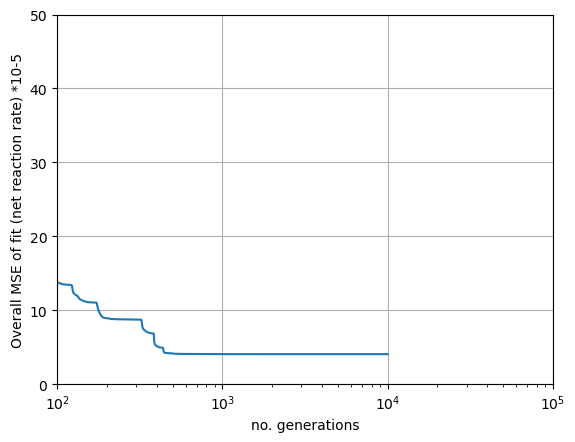

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

0.9916829560154942
8.494816370987644
8.509543467005011
0.651151235229137
7.814723091423256
7.797121108604839
7.785214476551859
0.2580455022769154
6.256860886613013
6.314458772728168
6.315834965092601
6.2641249542112964
1.1411546982966574
7.175270304694595
6.932205636565987
7.374396820288892
7.151397332611105
1.4213924741002413
7.4390308161221474
0.8354500702782933
7.844540444100728
7.827315831902299
7.850072864076765
6.853538525293459
0.6597361537114442
6.66904175856616
3.0565973817877947
6.075389921745107
8.066576002790155
8.055914816520138
0.6977143442472106
7.705490353748106
-1.301029999999932
0.24466279450306347


In [34]:
res.X

array([ 0.99168296,  8.49481637,  8.50954347,  0.65115124,  7.81472309,
        7.79712111,  7.78521448,  0.2580455 ,  6.25686089,  6.31445877,
        6.31583497,  6.26412495,  1.1411547 ,  7.1752703 ,  6.93220564,
        7.37439682,  7.15139733,  1.42139247,  7.43903082,  0.83545007,
        7.84454044,  7.82731583,  7.85007286,  6.85353853,  0.65973615,
        6.66904176,  3.05659738,  6.07538992,  8.066576  ,  8.05591482,
        0.69771434,  7.70549035, -1.30103   ,  0.24466279])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 0.9916829560154942
8.5: 8.494816370987644
8.5: 8.509543467005011
2.0: 0.651151235229137
9.0: 7.814723091423256
9.0: 7.797121108604839
9.0: 7.785214476551859
2.0: 0.2580455022769154
8.0: 6.256860886613013
8.0: 6.314458772728168
8.0: 6.315834965092601
8.0: 6.2641249542112964
2.0: 1.1411546982966574
8.0: 7.175270304694595
8.0: 6.932205636565987
8.0: 7.374396820288892
8.0: 7.151397332611105
2.0: 1.4213924741002413
8.0: 7.4390308161221474
1.0: 0.8354500702782933
8.0: 7.844540444100728
8.0: 7.827315831902299
8.0: 7.850072864076765
7.0: 6.853538525293459
1.0: 0.6597361537114442
7.0: 6.66904175856616
3.0: 3.0565973817877947
6.0: 6.075389921745107
8.0: 8.066576002790155
8.0: 8.055914816520138
1.0: 0.6977143442472106
8.0: 7.705490353748106
0.10000000000000002: 0.24466279450306347
coeff fit: 0.9165932116811705
r: 0.957388746372742
